Time tracking: 28h

In [1]:
import pandas as pd
import joblib
import shap
from shap.maskers import Independent
import matplotlib.pyplot as plt
from comparers import ModelComparer, plot_decision_boundary, _encode_one_hot, _calc_log_odds_from_log_proba
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations, ensure_shap_values_are_3d
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from matplotlib.colors import Normalize
import scipy as sp
from util import get_rules
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '02'

In [2]:
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)
with open(task_name + '.expl', 'rb') as f:
    explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)

In [3]:
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor

In [4]:
X = pd.read_csv('test_data.csv')
y = X['price']
X = X.drop(columns=['Unnamed: 0', 'price'])
feature_names = X.columns.to_numpy()
class_names = y.unique().astype(str)
X = X.to_numpy()
y = y.to_numpy()

In [5]:
y = y.astype(str)
d = dict([(feature_name, feature_data)
          for feature_name, feature_data
          in zip(feature_names, [x for x in X.T])])
d |= {'y': y}
df = pd.DataFrame(d)
dataset = prepare_df(df, 'test', 'y')

# Local Explanations

Now, having analyzed the global effects and also discovered the most obvious effects of the most important feature (LSTAT), I will analyze the instances where both classifiers disagree in their predictions on a local level. Let the local level be defined as the set of instances, that have similar difference class SHAP values in log odds space.

To achieve this, I will use hierarchical clustering and extract all clusters, where instances are present, for which the classifiers disagree. For each cluster, I will search for the closest boundary. That means, I will use different visualization and aggregation techniques to find out which feature has the second biggest influence on the decision between the confusion class and a class, where both classifiers agree. Finally, I will test, how much of that feature needs to be changed in order for both classifiers to agree on a specific class. 

In [6]:
shap_values = explanations.mclass_diff.log_odds[:, :, :]
shap_values = ensure_shap_values_are_3d(shap_values)
values = shap_values.values.reshape(
        (shap_values.values.shape[0],
         shap_values.values.shape[1] * shap_values.values.shape[2]))
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

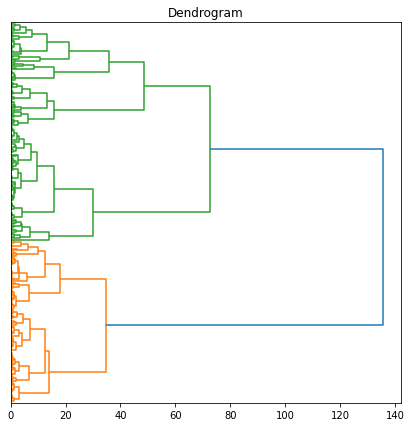

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

I tried extracting different numbers of clusters, but 25 gave the most reasonable results. This yielded 9 clusters with instances that are classified differently, few enough to be analyzed separately. Each of these only contains instances of one confusion class and one to two neighboring equality classes.

In [8]:
n_clusters = 25
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')
clustering -= 1

In [9]:
explanations_clustered = explanations.cohorts(cluster_names[clustering])

Next, we see the instance counts per cluster per difference class.

In [10]:
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c3,13,4,0,0,0,0,0,0,0
c4,9,2,0,0,0,0,0,0,0
c6,1,3,0,0,12,0,0,0,0
c7,0,1,0,0,3,0,0,0,0
c8,3,3,0,0,1,0,0,0,0
c15,0,0,0,0,9,0,0,1,0
c20,0,0,0,0,0,0,0,1,2
c24,0,0,0,0,2,0,0,1,0
c25,0,0,0,0,7,1,0,0,0


When inspecting the feature value distributions of each cluster, we notice, that every cluster covers a different value range of LSTAT. This could mean, that the local effects depend on the value of LSTAT, the most important feature.

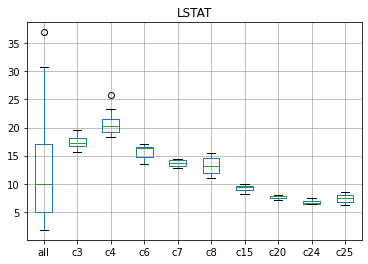

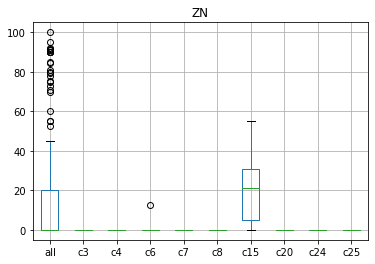

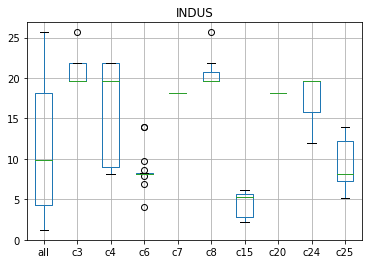

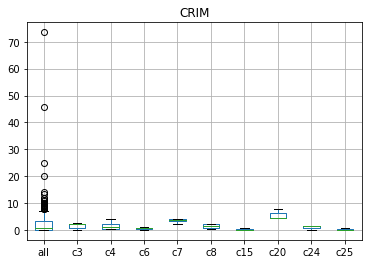

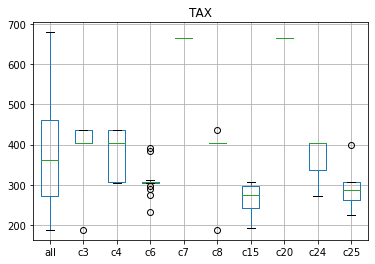

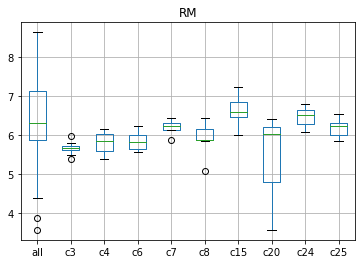

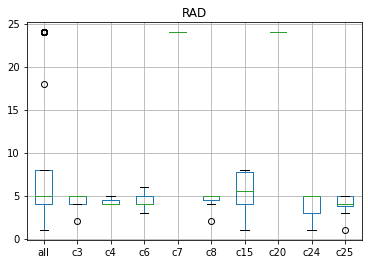

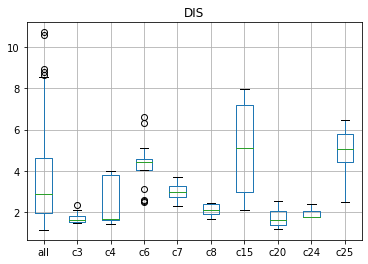

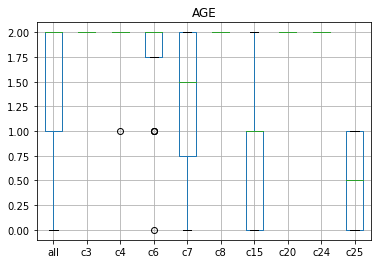

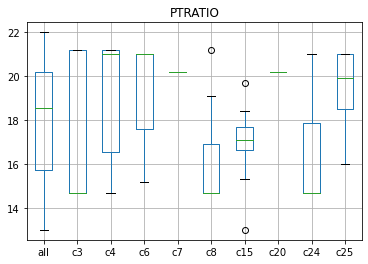

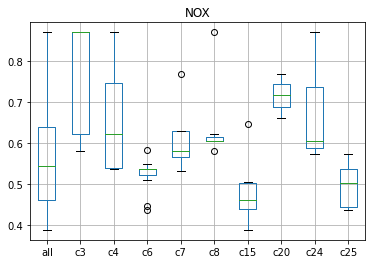

In [11]:
for feature_name in comparer.feature_names[feature_order]:
    df = pd.concat([pd.Series(explanations[:, feature_name].data)] +
                   [pd.Series(explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, feature_name].data)
                    for cluster in clusters_of_interest], axis=1)
    df.columns = ['all'] + clusters_of_interest.tolist()
    df.boxplot()
    plt.title(feature_name)
    plt.show()

In [12]:
feature_idx_of = lambda feature_name: np.where(comparer.feature_names == feature_name)[0][0]
class_idx_of = lambda class_name: np.where(comparer.class_names == class_name)[0][0]

In [13]:
def plot_decision(shap_values, highlight=None):
    plt.title(shap_values.output_names)
    shap.decision_plot(shap_values.base_values[0], shap_values.values, shap_values.feature_names,
                       highlight=highlight)

In [14]:
def plot_diro2c(X_diff, y_diff, feature_x, feature_y, xlim=None, ylim=None):
    idx_x, idx_y = feature_idx_of(feature_x), feature_idx_of(feature_y)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    for class_idx, class_label in [(0, 'no_diff'), (1, 'diff')]:
        mask = y_diff == class_idx
        ax.scatter(X_diff[mask, idx_x], X_diff[mask, idx_y], label=class_label, alpha=0.5)
    ax.legend()

## 1st cluster (mean LSTAT = 17.4)

In [140]:
cluster = clusters_of_interest[0]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

The decision plot shows for all instances of the cluster, how the finally predicted log odds value for a difference class is calculated. The bold, dotted lines highlight instances with differing predictions. It is a good way to check visually, if the cluster is homogenous, and what the main differences are between the instances with equal predictions and different predictions. In this case, we notice that CRIM and PTRATIO split the decisions for class $(0,0)$ log odds in two parts. The decisions for $(0,1)$ appear very similar.

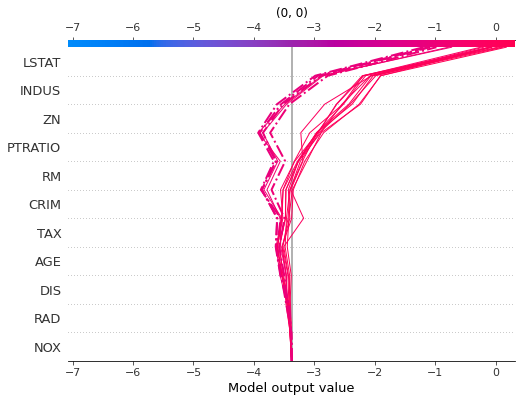

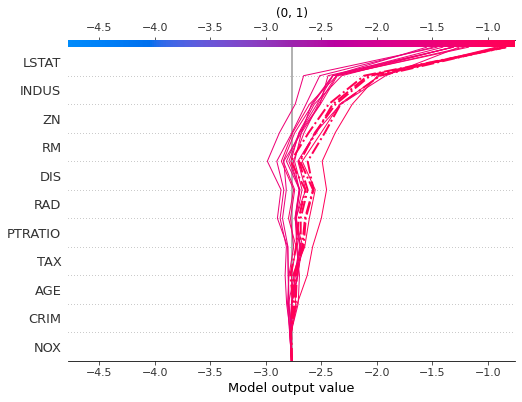

In [16]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

With the difference of the aggregated (mean) SHAP values for these two classes, I can confirm that PTRATIO and CRIM are in the top influences that differ between the two groups. Aside from LSTAT, INDUS has high influence differences as well. Please note, that for the confusion class, positive differences are relevant, and for the other class(es), negative differences are relevant, because they can be decreased in order for the prediction to change to the class, where both classifiers predict the same.

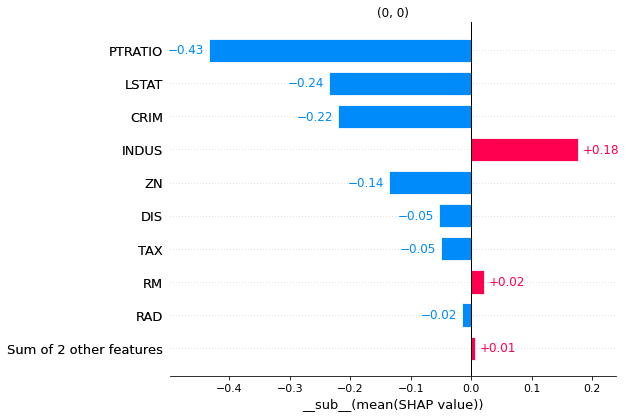

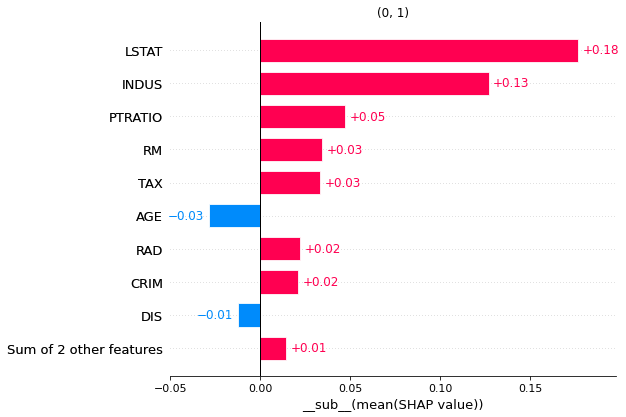

In [17]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

So let's check these features values and effects:

In [18]:
top_features = ['LSTAT', 'PTRATIO', 'CRIM', 'INDUS']

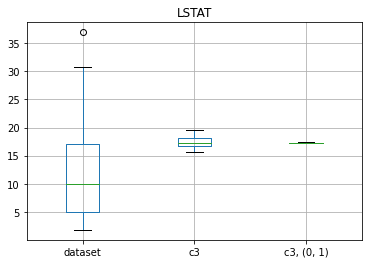

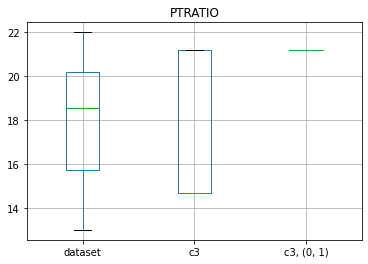

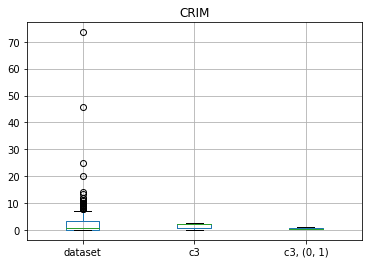

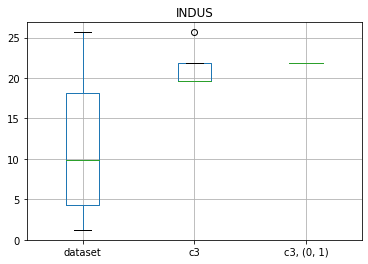

In [19]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

### Feature effects

The log odds of $(0,0)$ may be increased when PTRATIO is decreased, or when CRIM is increased. Probably increasing INDUS would work as well, but, then the log odds of $(0,1)$ would be increased as well.

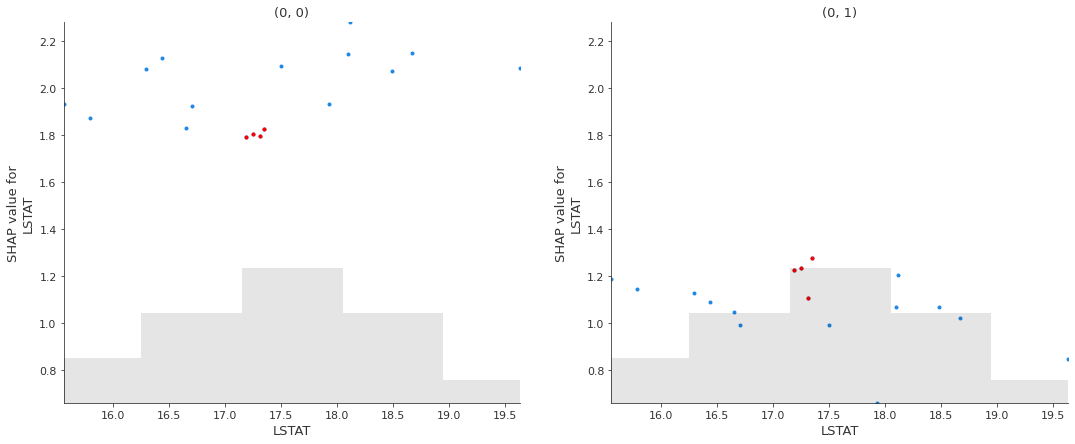

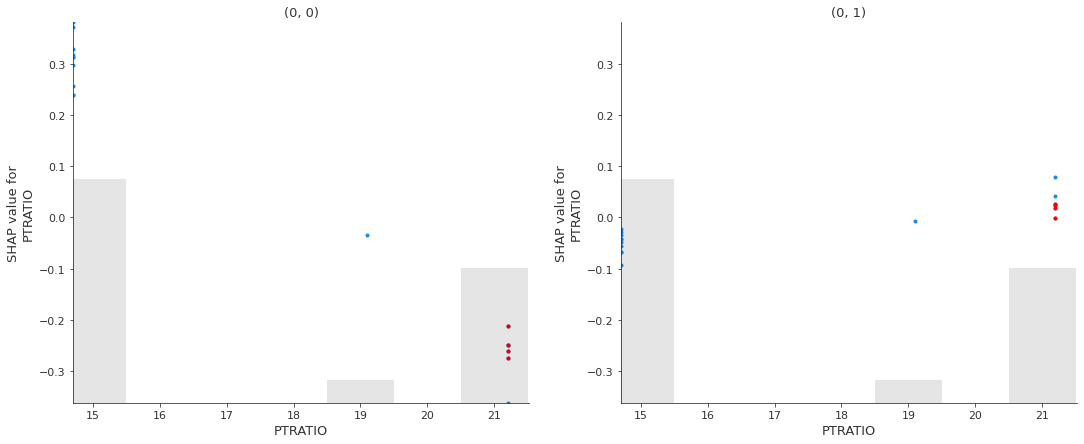

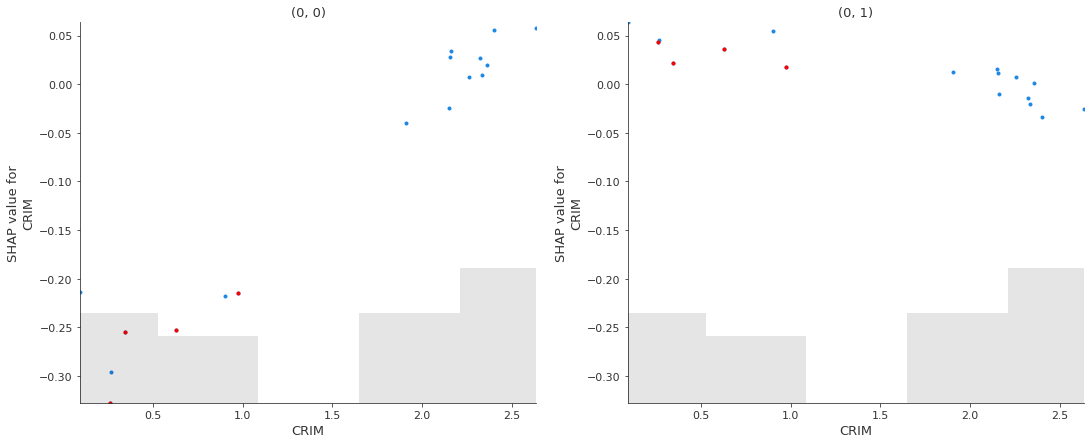

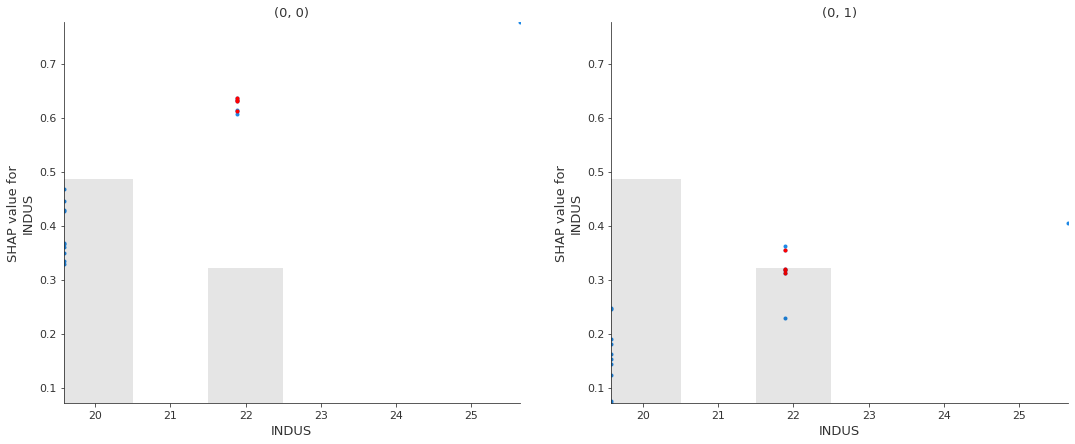

In [20]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the feature's value, I found out that the classifiers don't agree always for these instances:
- PTRATIO: 19.5 - 25.4
- CRIM: up to 1.83

In [21]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] -= 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [21.2 21.2 21.2 21.2]
stop:  [19.5 19.5 19.5 19.5]


In [22]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [21.2 21.2 21.2 21.2]
stop:  [25.4 25.4 25.4 25.4]


In [23]:
idx_feature = feature_idx_of('CRIM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] += 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [0.62683678 0.97617    0.25915    0.34474464]
stop:  [1.82683678 2.17617    1.45915    1.54474464]


In [24]:
idx_feature = feature_idx_of('CRIM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [0.62683678 0.97617    0.25915    0.34474464]
stop:  [-2.37316322 -2.02383    -2.74085    -2.65525536]


### diro2c

diro2c is another local interpretability approach, based on LORE. It generates new instances, especially in the areas where differences occur, using a genetic neighborhood generation algorithm. It cannot yet create explanations for individual confusion classes of multiclass classifiers, but it can create explanations for the binary difference classifier. This means, that not only the current confusion class of interest is show in its explanations, but also all other.

Here I use it to create another local explanation for the first instance of this cluster as the starting point.

In [141]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 45.1 s, sys: 439 ms, total: 45.5 s
Wall time: 49.4 s


In the next plot, CRIM and PTRATIO are shown along with LSTAT. I chose LSTAT because it enables us to distinguish the main confusion classes: $(0,1)$ and $(1,0)$ around 10-20, $(1,2)$ and $(2,1)$ around 5-10.

Additionally to the value ranges identified before, it found differences for PTRATIO < 19.5 and for CRIM > 1.83. It also generated instances with unrealistic CRIM values that never occured in the original data (below 0). Since it works with integer values only, the resolution is not very detailled.

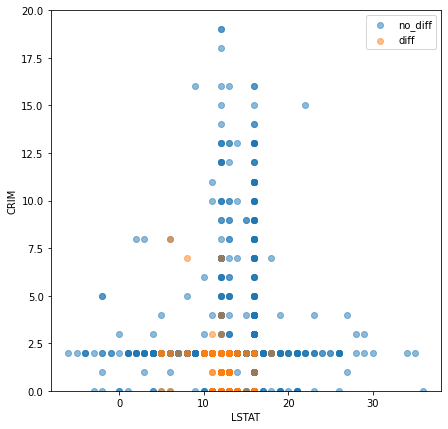

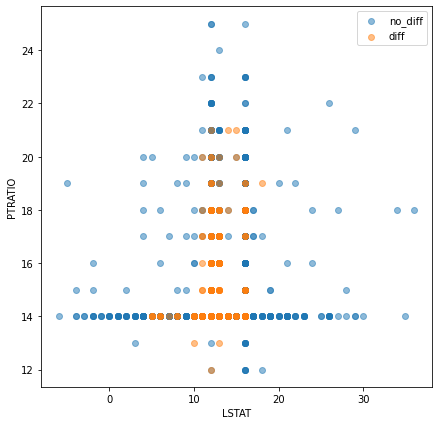

In [142]:
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'CRIM', ylim=(0, 20))
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'PTRATIO')

Since the decision tree generated is too big to be analyzed, only the first two layers are shown. We see that it splits by LSTAT and CRIM confirming the importance of these two features. And it discriminates by CRIM <= 0.5, which is a bit lower, but confirms our finding that for low CRIM values there is an increased number of different classifications.

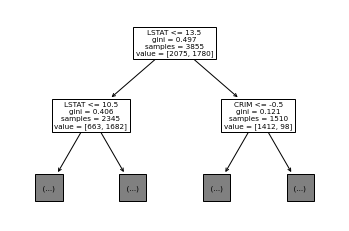

In [27]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 2nd cluster (mean LSTAT = 20.8)

In [28]:
cluster = clusters_of_interest[1]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

In the next cluster, we see that for instances with different predictions INDUS has unusually big negative effects on class $(0,0)$.

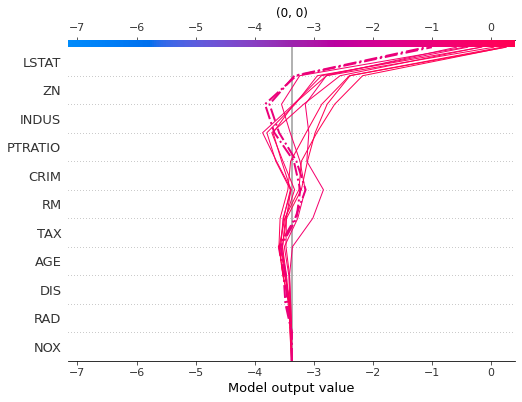

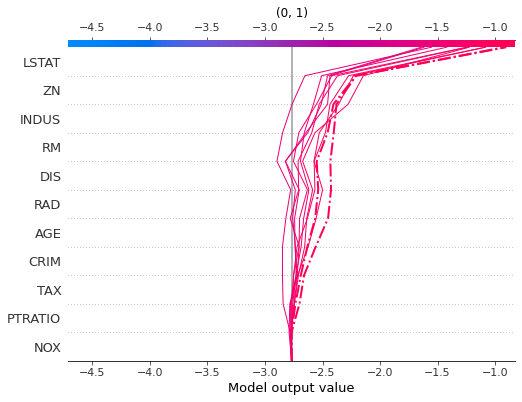

In [29]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

The biggest forces besides LSTAT are INDUS and PTRATIO, both lessening the log odds of $(0,0)$ for instances with different predictions.

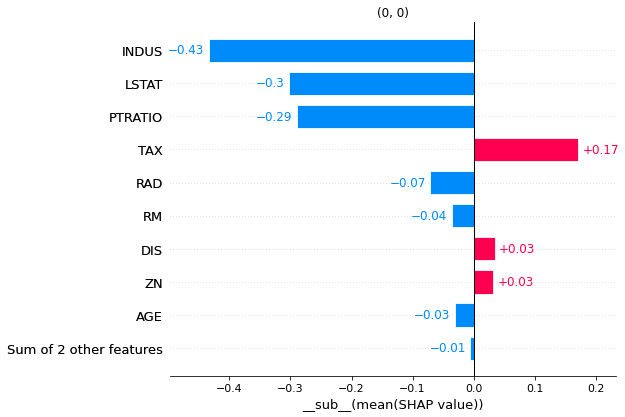

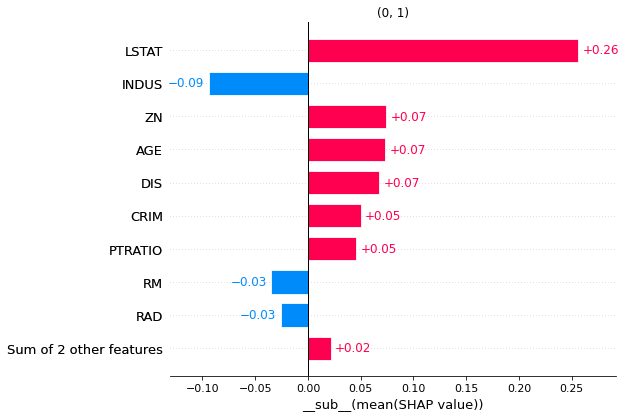

In [30]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [31]:
top_features = ['INDUS', 'PTRATIO']

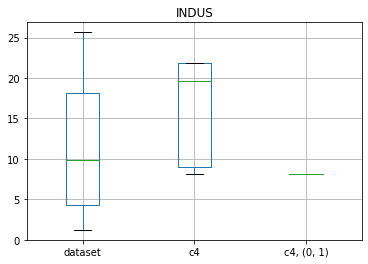

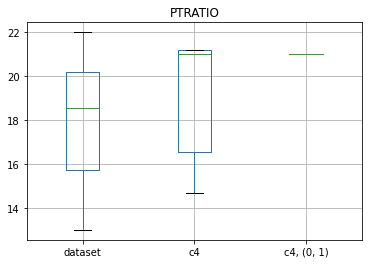

In [32]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

### Feature effects

The log odds of $(0,0)$ may be increased when INDUS is increased, or when PTRATIO is decreased.

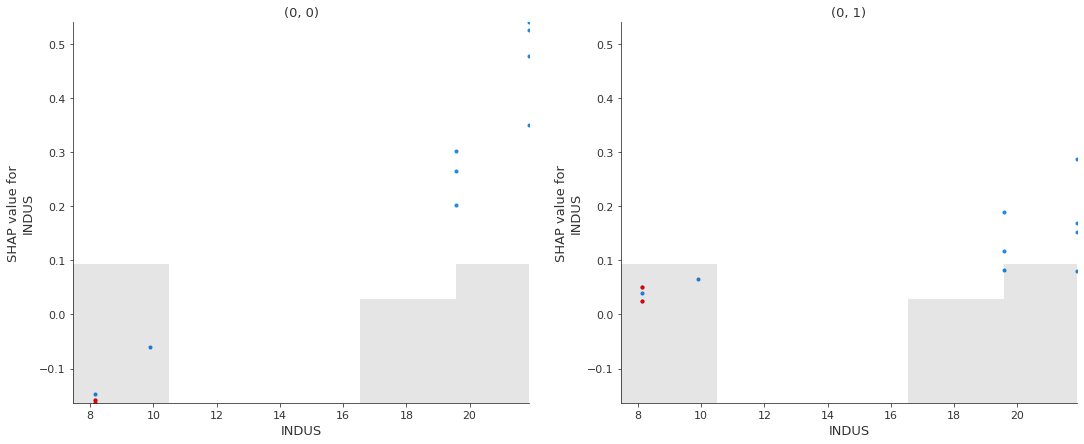

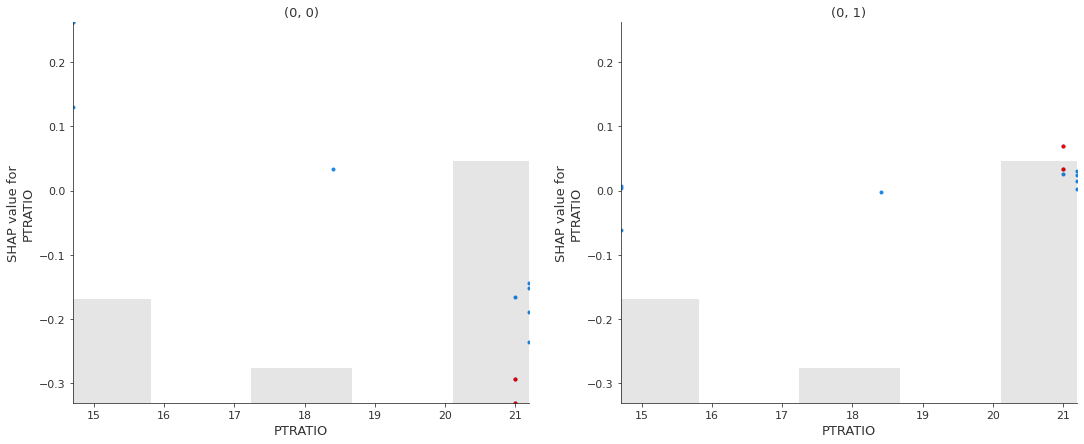

In [33]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the feature's value, I found out that the classifiers don't agree for these instances in the ranges:
- INDUS: up to 10.64
- PTRATIO: 20 - 24.8

In [34]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [8.14 8.14]
stop:  [10.64 10.64]


In [35]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [8.14 8.14]
stop:  [-0.75 -0.75]


In [36]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] -= 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [21. 21.]
stop:  [20. 20.]


In [37]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [21. 21.]
stop:  [24.8 24.8]


### diro2c

In [38]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 42.8 s, sys: 306 ms, total: 43.1 s
Wall time: 52 s


This confirms our previous finding, that between PTRATIO 20 and 25, possibly focused on 21, are the most differences. But we see more for INDUS = 6 for lower values of PTRATIO and more for higher PTRATIO values.

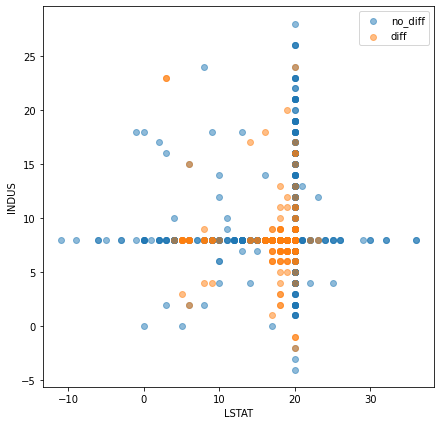

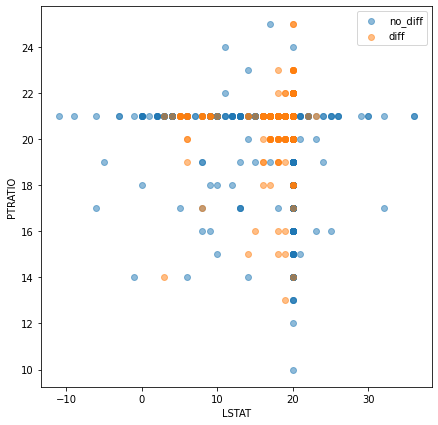

In [39]:
for feature in ['INDUS', 'PTRATIO']:
    plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

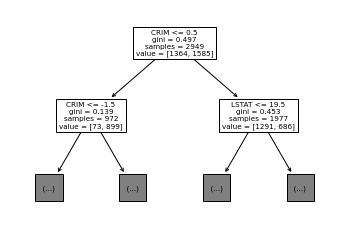

In [40]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 3rd cluster (mean LSTAT = 15.8)

In [41]:
cluster = clusters_of_interest[2]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

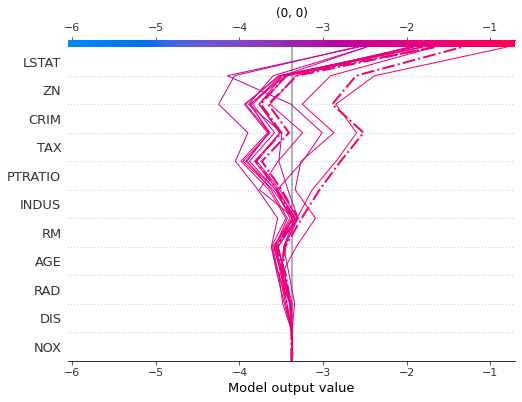

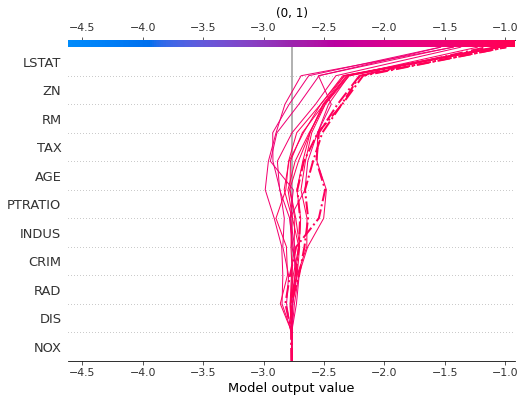

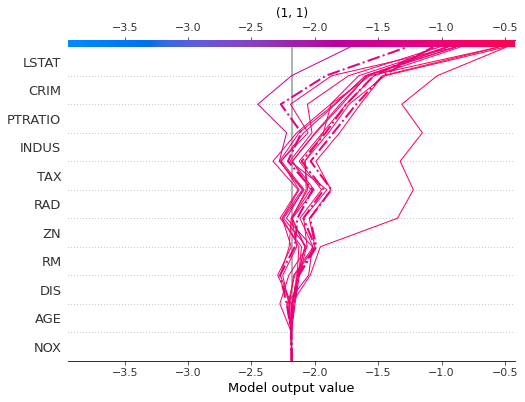

In [42]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

We see notable differences for the features INDUS, PTRATIO, TAX and DIS.

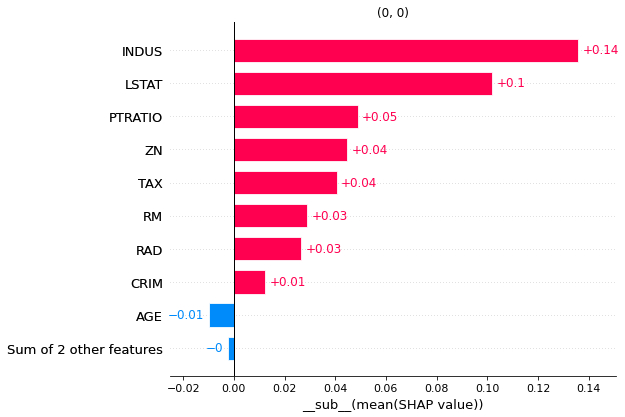

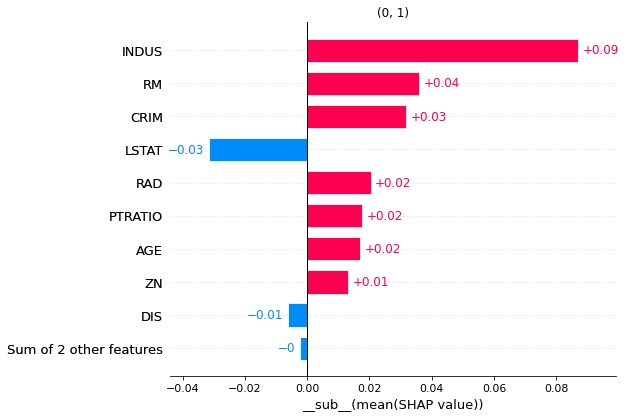

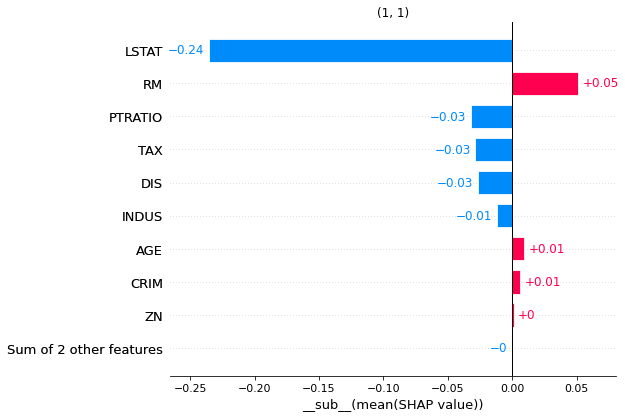

In [43]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [44]:
top_features = ['INDUS', 'PTRATIO', 'TAX', 'DIS']

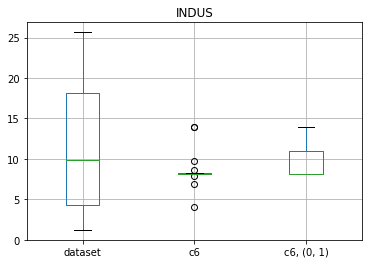

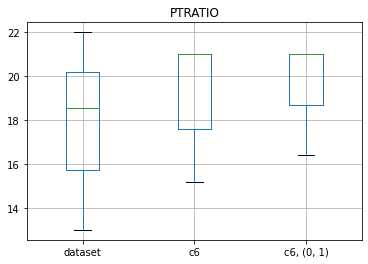

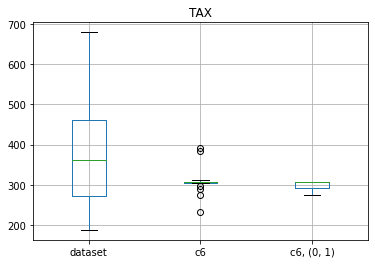

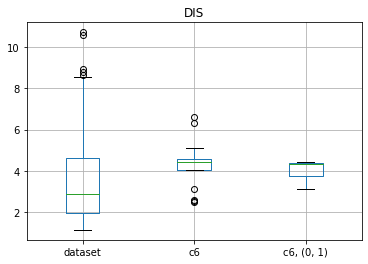

In [45]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

### Feature effects

The log odds of $(0,1)$ may be decreased when INDUS is decreased. The log odds of $(1,1)$ may be increased if PTRATIO, TAX or DIS is increased.

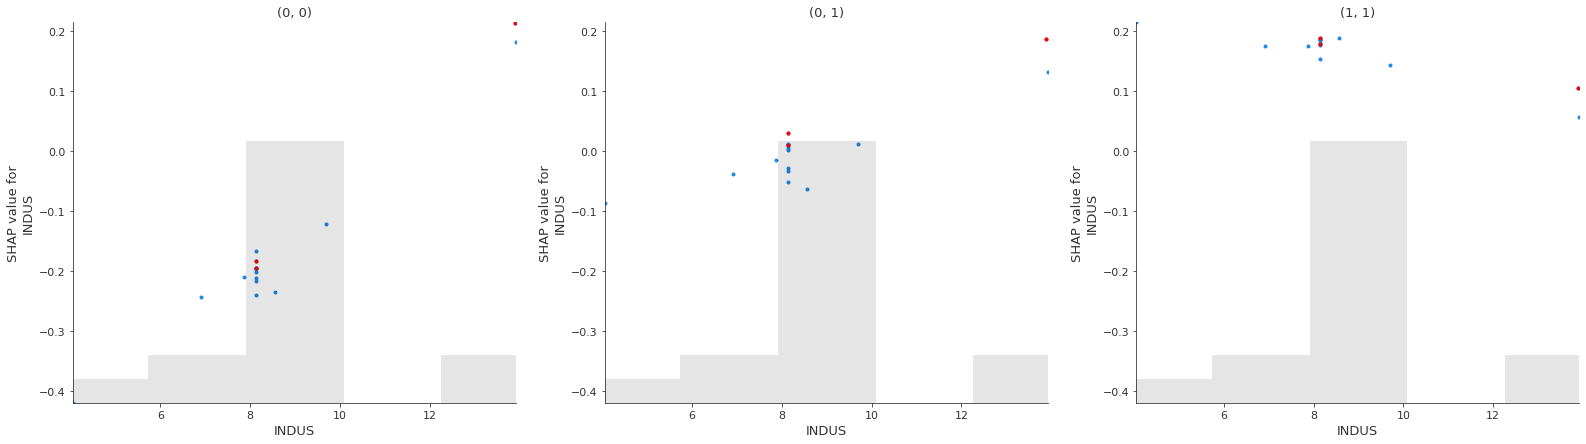

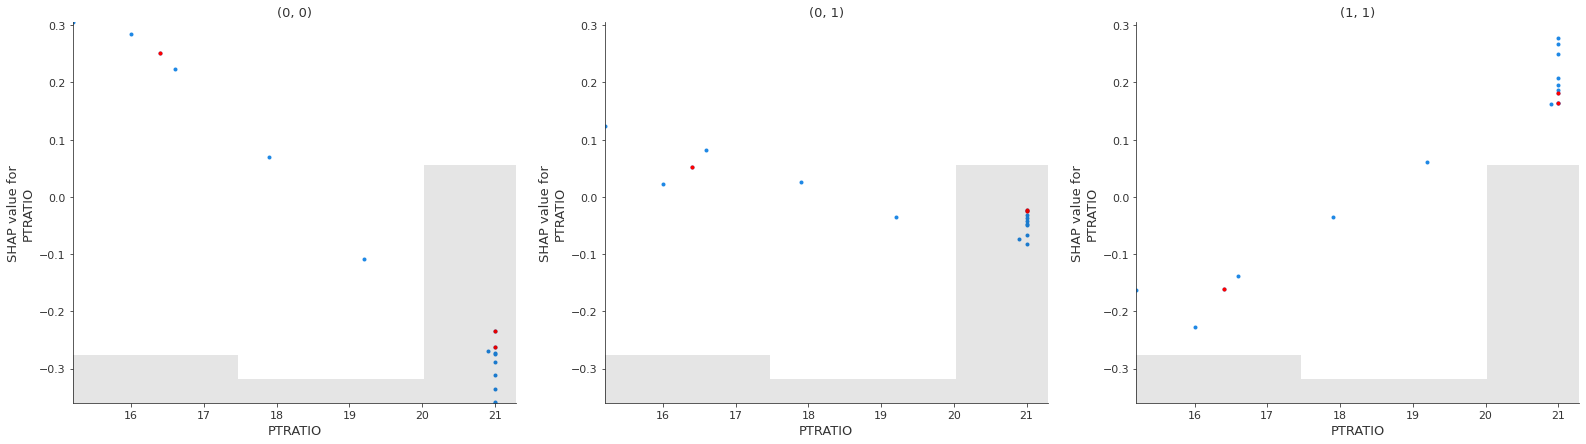

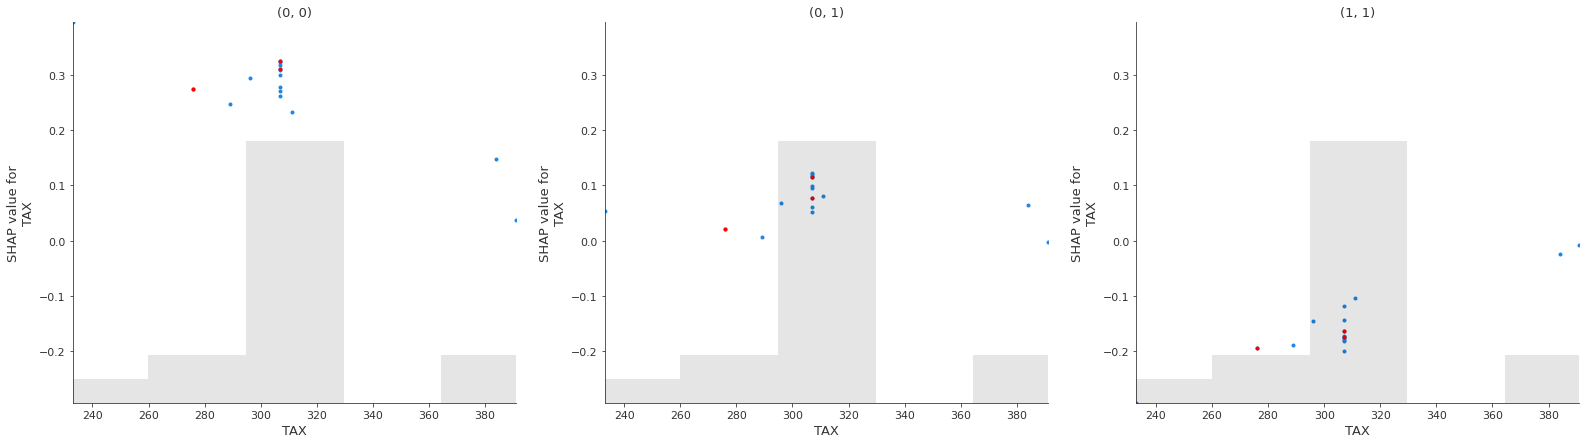

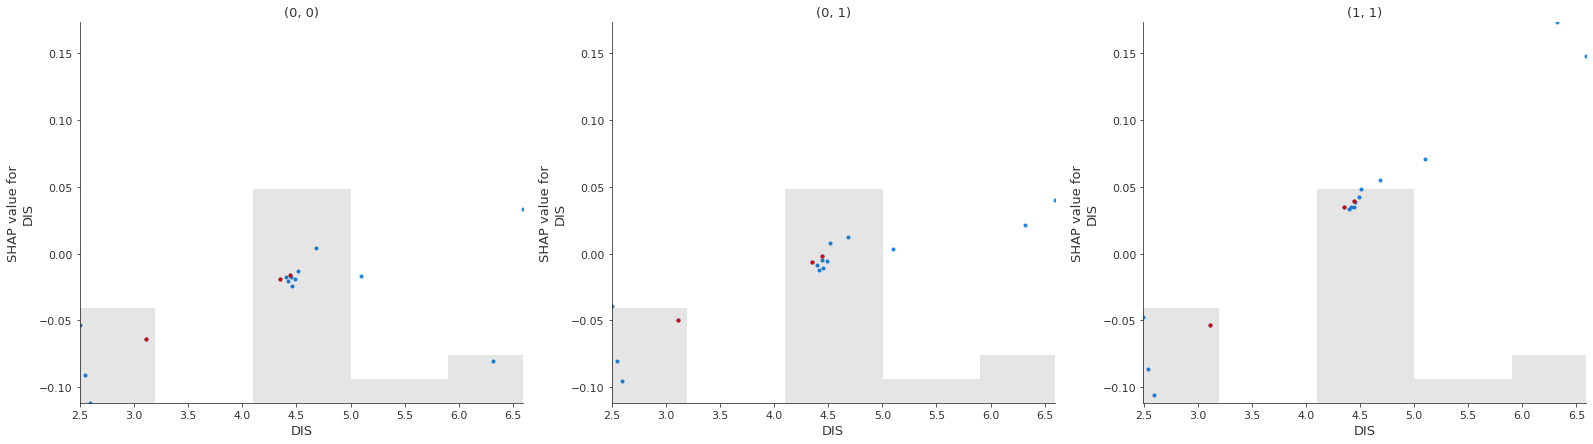

In [46]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the features' values, I found out that the classifiers don't always agree for these instances in the ranges:
- INDUS: 6.62 - 18.44, 12.37 - 24.19
- PTRATIO: 17.1 - 21.7, 12.5 - 17.1
- TAX: 115 - 335, 84 - 304
- DIS: up to 6.7, up to 5.4

Please note, that there are instances with similar effects but different feature values in this cluster.

In [47]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [ 8.14  8.14 13.89]
stop:  [ 6.62  6.62 12.37]


In [48]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [ 8.14  8.14 13.89]
stop:  [18.44 18.44 24.19]


In [49]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [21.  21.  16.4]
stop:  [21.7 21.7 17.1]


In [50]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] -= 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [21.  21.  16.4]
stop:  [17.1 17.1 12.5]


In [51]:
idx_feature = feature_idx_of('TAX')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [307. 307. 276.]
stop:  [335. 335. 304.]


In [52]:
idx_feature = feature_idx_of('TAX')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] -= 1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [307. 307. 276.]
stop:  [115. 115.  84.]


In [53]:
idx_feature = feature_idx_of('DIS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [4.44168999 4.350506   3.1121    ]
stop:  [6.69168999 6.600506   5.3621    ]


### diro2c

In [54]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 43.8 s, sys: 307 ms, total: 44.1 s
Wall time: 1h 4min 18s


diro2c found differences for INDUS, PTRATIO and DIS in the same ranges. For TAX it found even more difference for higher values. It offers a good view on combinations of these values, where differences occur less often.

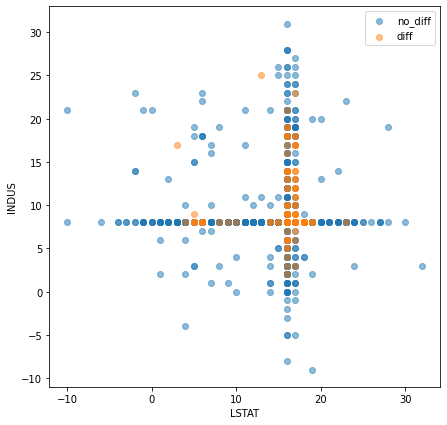

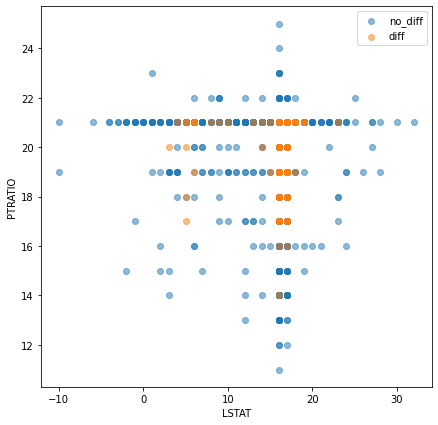

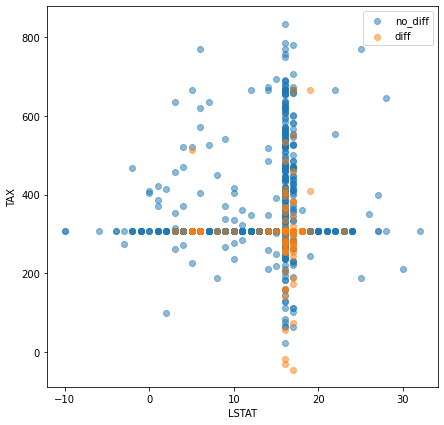

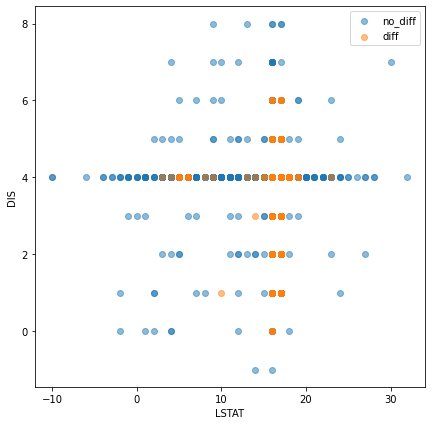

In [55]:
for feature in ['INDUS', 'PTRATIO', 'TAX', 'DIS']:
    plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

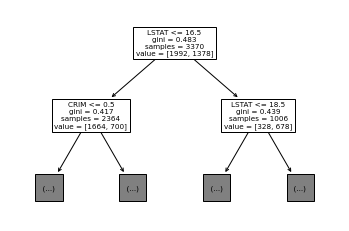

In [56]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 4th cluster (mean LSTAT = 13.7)

In [57]:
cluster = clusters_of_interest[3]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

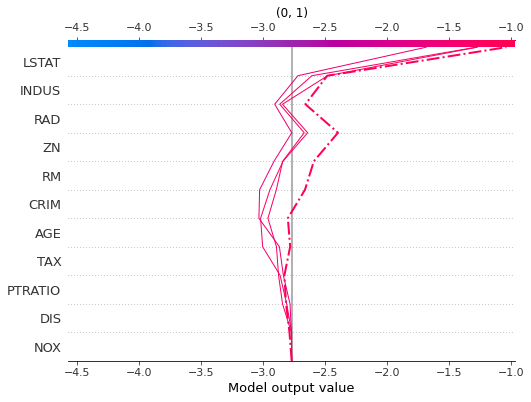

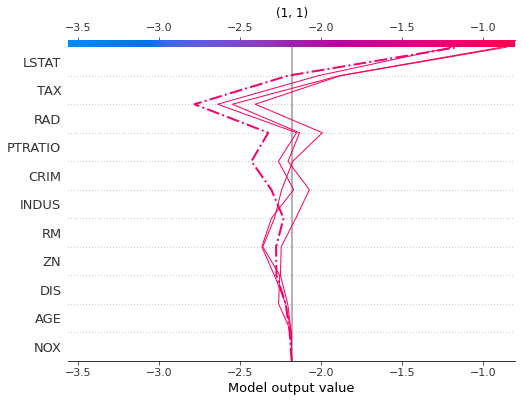

In [58]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

Besides LSTAT, we see TAX and CRIM increasing the log odds for $(0,1)$, INDUS and CRIM decreasing the log odds for $(1,1)$.

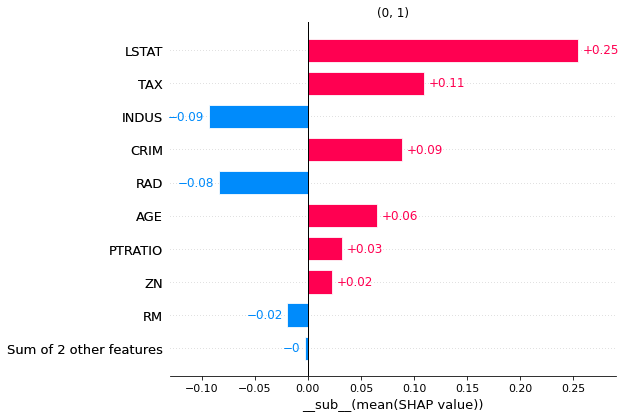

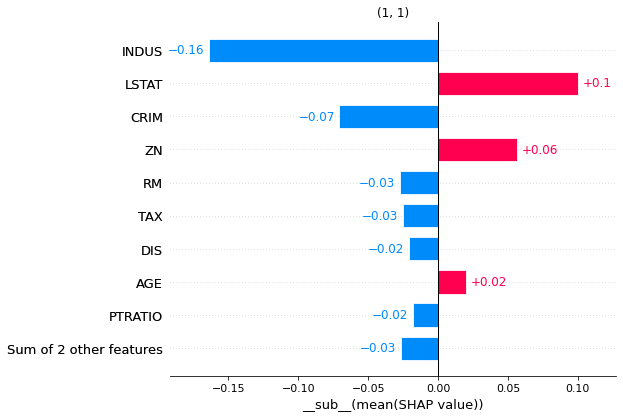

In [59]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [60]:
top_features = ['INDUS', 'TAX', 'CRIM']

Since all instances in the cluster have the same values for INDUS and TAX, we skip them. This implies that interactions with other features cause these influence differences.

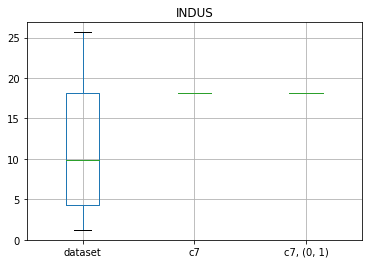

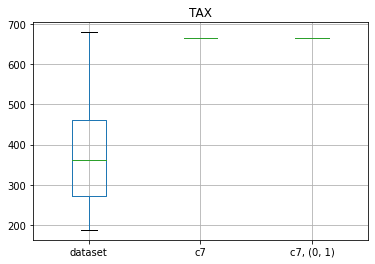

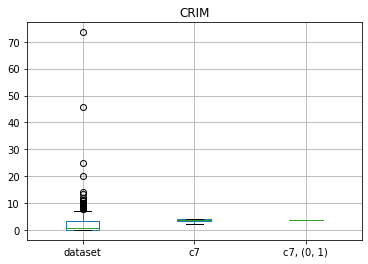

In [61]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

In [62]:
top_features = ['CRIM']

### Feature effects

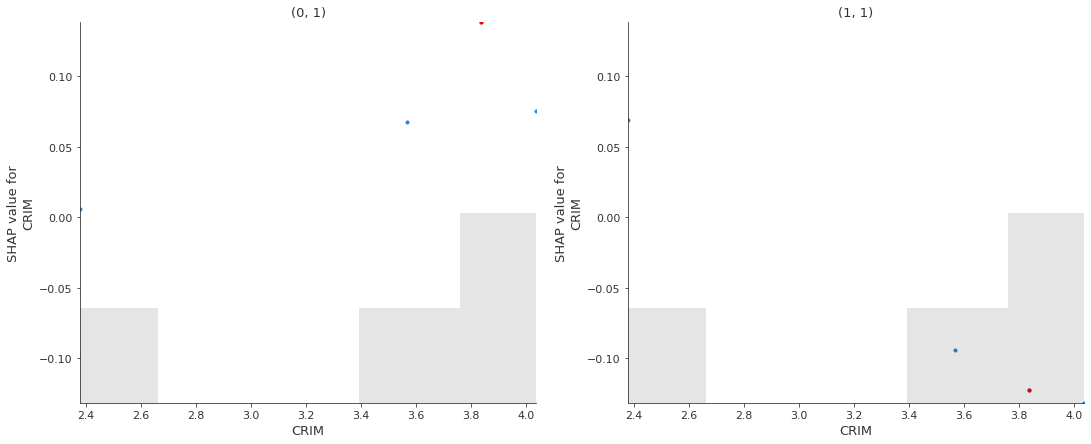

In [63]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the features' values, I found out that the classifiers don't always agree for these instances in the ranges:
- CRIM: 3.46-6.21

In [64]:
idx_feature = feature_idx_of('CRIM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [3.83684]
stop:  [3.45684]


In [65]:
idx_feature = feature_idx_of('CRIM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [3.83684]
stop:  [6.20684]


### diro2c

In [66]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 57.1 s, sys: 751 ms, total: 57.9 s
Wall time: 1min 9s


diro2c confirms, that many differences occur around CRIM=3 and up to 6. But it also found further for smaller feature values, and even sampled from unrealistic negative values.

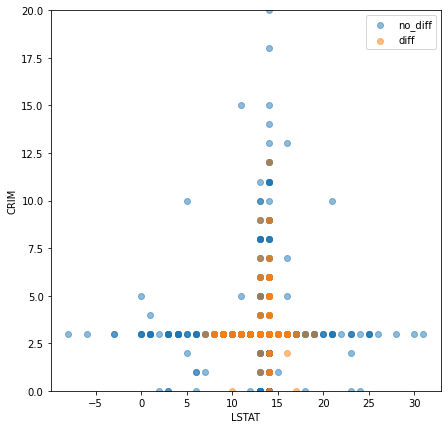

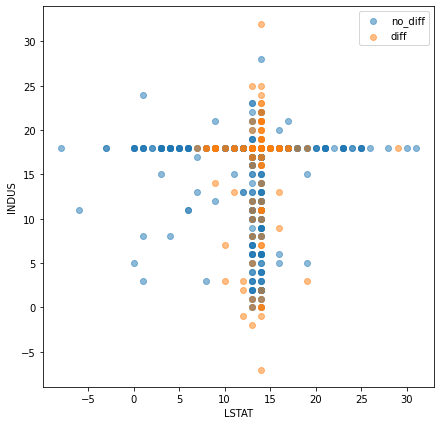

In [67]:
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'CRIM', ylim=(0, 20))
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'INDUS')

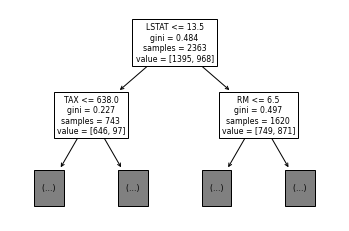

In [68]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 5th cluster (mean LSTAT = 13.2)

In [69]:
cluster = clusters_of_interest[4]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

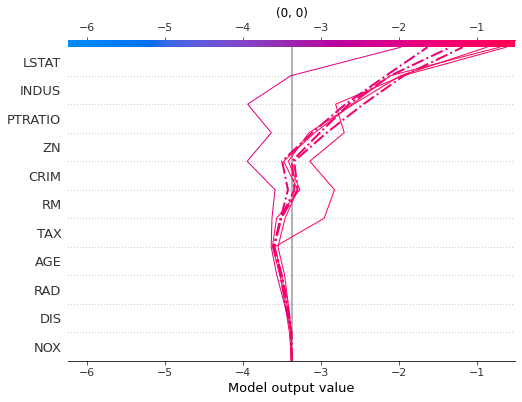

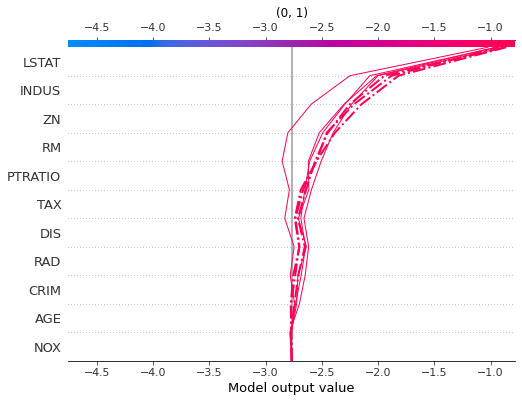

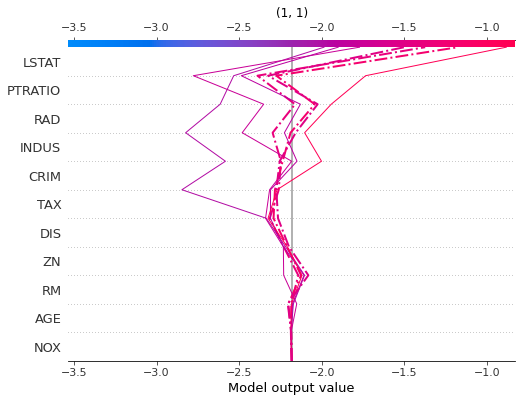

In [70]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

Besides LSTAT, we see PTRATIO and INDUS increasing the log odds for $(0,1)$, TAX and INDUS decreasing the log odds for $(0,0)$ and CRIM and PTRATIO decreasing the log odds for $(1,1)$.

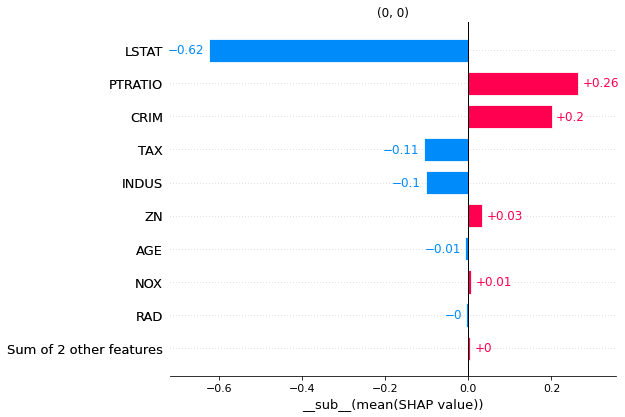

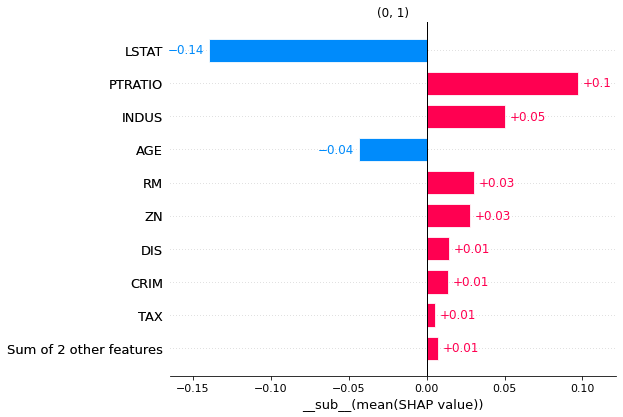

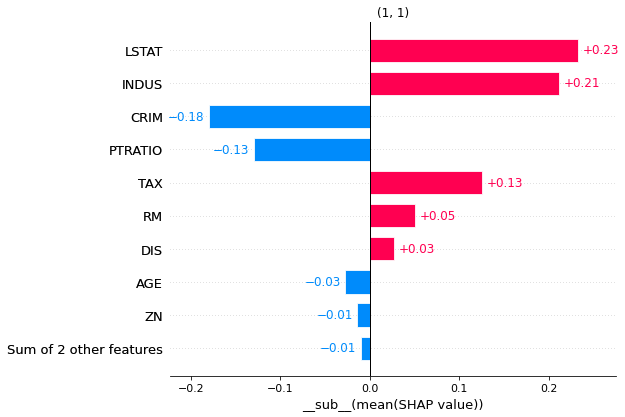

In [71]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [72]:
top_features = ['PTRATIO', 'INDUS', 'TAX', 'CRIM']

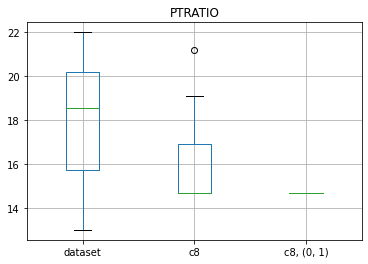

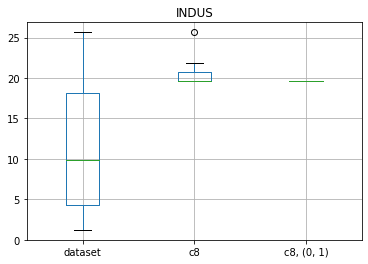

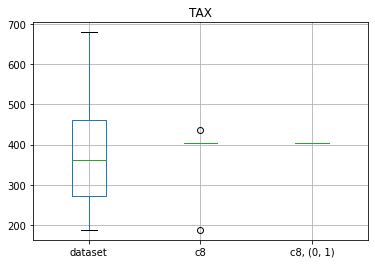

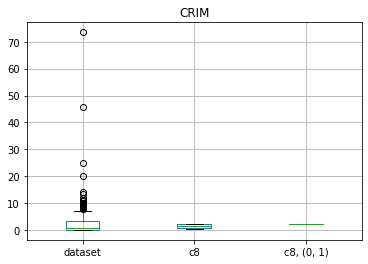

In [73]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

### Feature effects

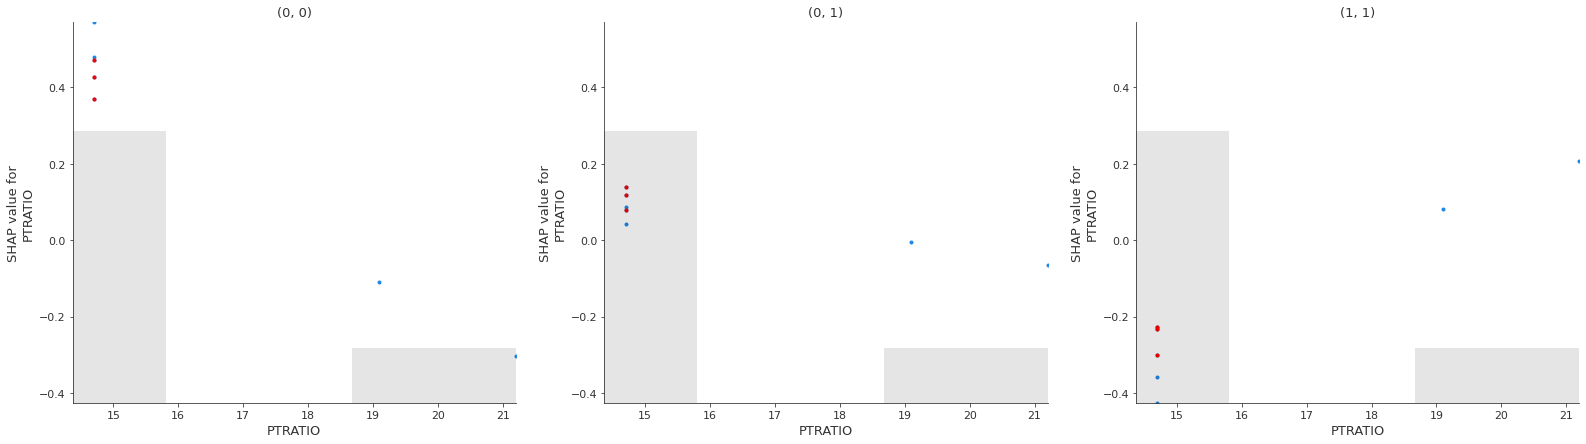

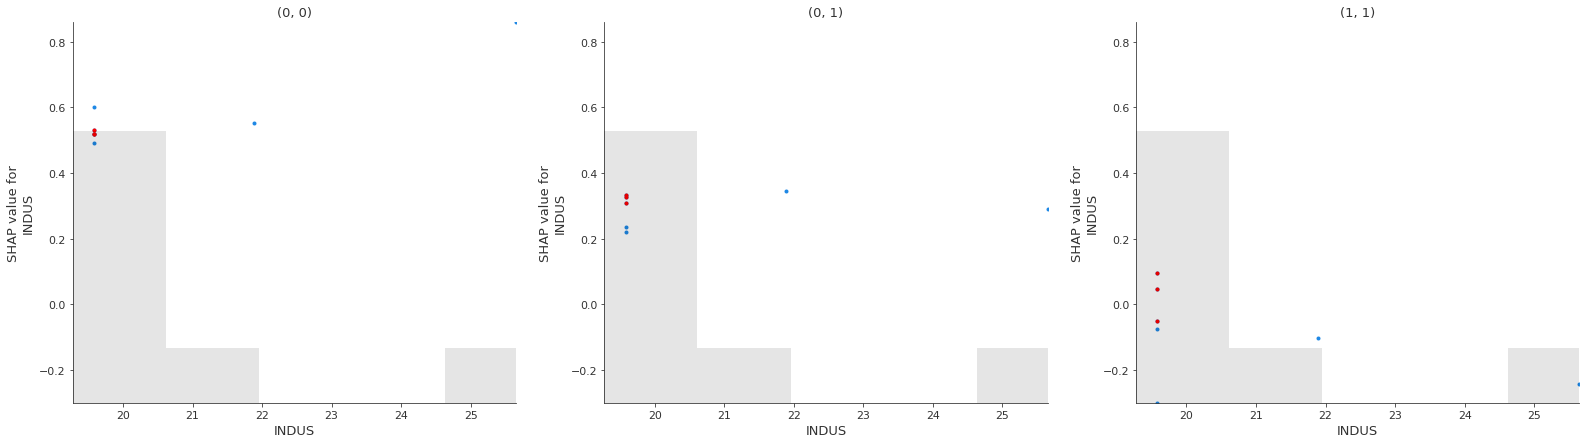

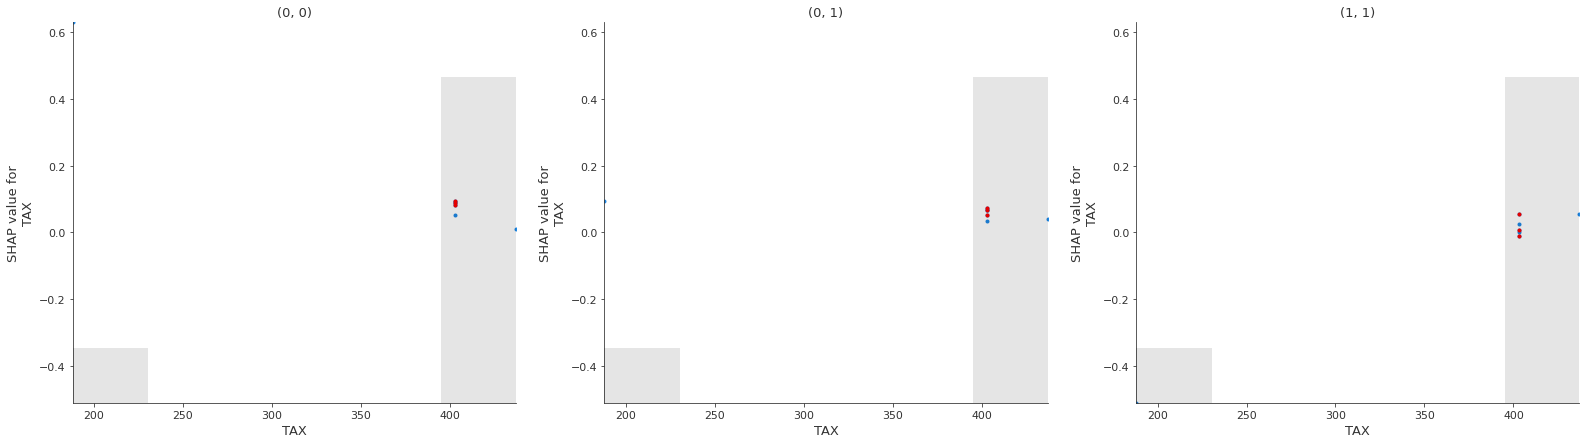

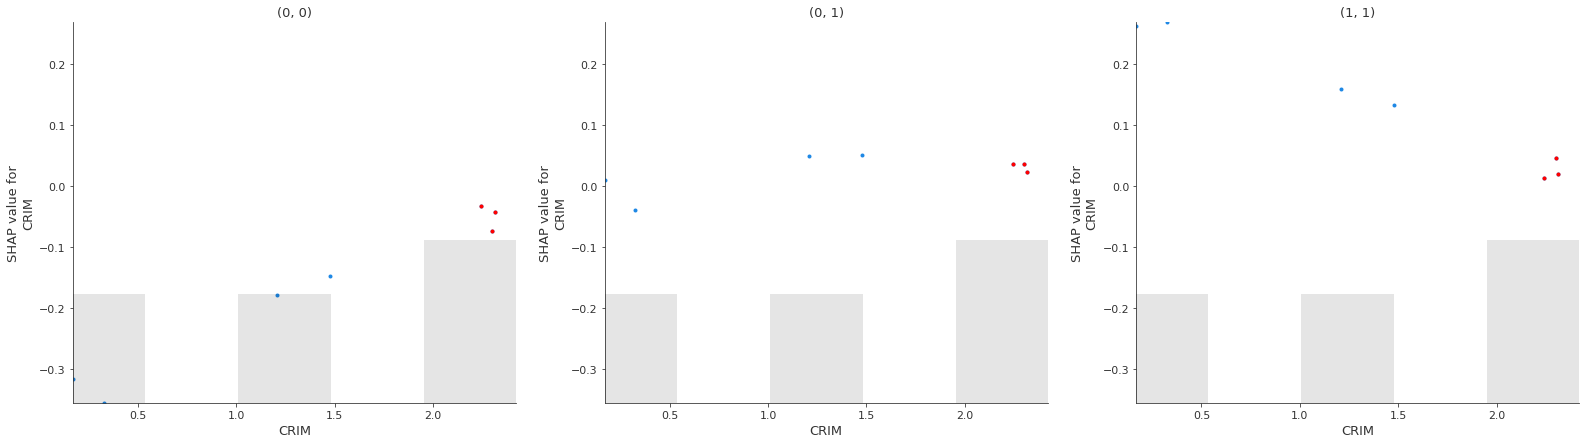

In [74]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the features' values, I found out that the classifiers don't always agree for these instances in the ranges:
- PTRATIO: 11.01 - 17.93
- INDUS: 12.03 - 29.32
- TAX: 222 - 542
- CRIM: 0 - 4.8

In [75]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [14.7 14.7 14.7]
stop:  [17.93 17.93 17.93]


In [76]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [14.7 14.7 14.7]
stop:  [11.01 11.01 11.01]


In [77]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [19.58 19.58 19.58]
stop:  [29.32 29.32 29.32]


In [78]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [19.58 19.58 19.58]
stop:  [12.03 12.03 12.03]


In [79]:
idx_feature = feature_idx_of('TAX')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] -= 1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [403. 403. 403.]
stop:  [222. 222. 222.]


In [80]:
idx_feature = feature_idx_of('TAX')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [403. 403. 403.]
stop:  [542. 542. 542.]


In [81]:
idx_feature = feature_idx_of('CRIM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [2.24236 2.3004  2.3139 ]
stop:  [-0.05764  0.0004   0.0139 ]


In [82]:
idx_feature = feature_idx_of('CRIM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(0, 0)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [2.24236 2.3004  2.3139 ]
stop:  [4.76236 4.8204  4.8339 ]


### diro2c

In [83]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 46.7 s, sys: 470 ms, total: 47.2 s
Wall time: 51.9 s


For PTRATIO it didn't find differences as low as 11, but found further up to 21. For INDUS it basically confirms our previous finding, but suggests that there might be differences for higher feature valeus as well.

For TAX it confirms our findings, and suggests that there are more difference for lower feature values. For TAX, it also confirms our findings, and suggests that the actual decision boundary ends at 6, with possible outliers further up.

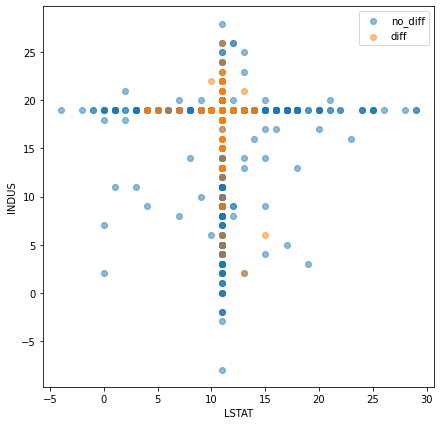

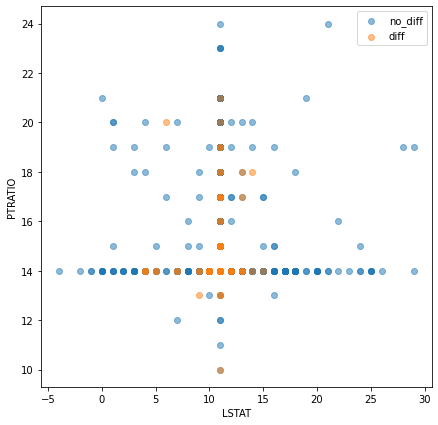

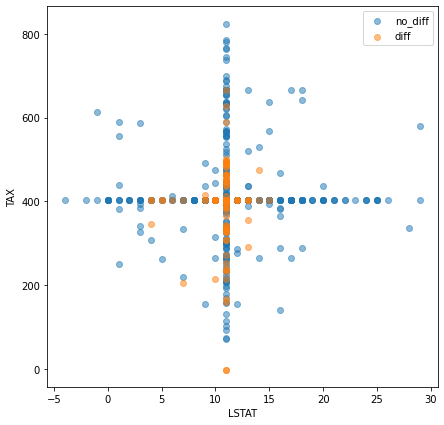

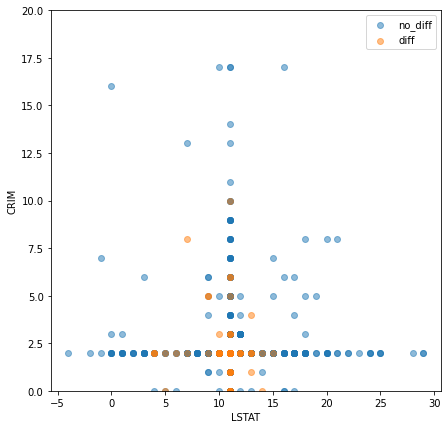

In [84]:
for feature in ['INDUS', 'PTRATIO', 'TAX']:
    plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'CRIM', ylim=(0, 20))

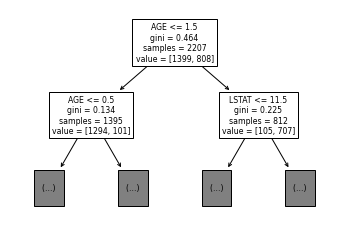

In [85]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 6th cluster (mean LSTAT = 9.2)

In [86]:
cluster = clusters_of_interest[5]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

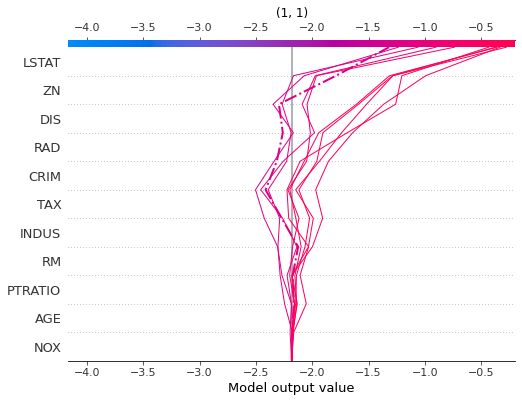

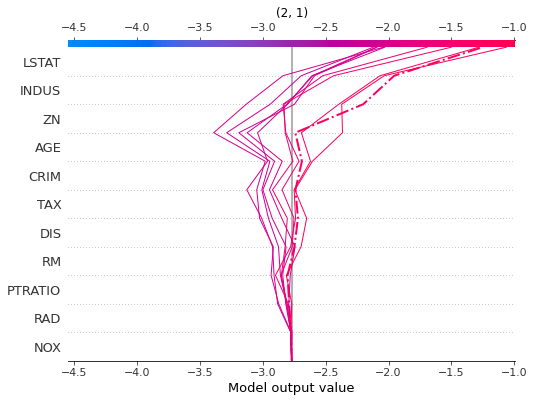

In [87]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

We see mainly ZN increasing the log odds for $(2,1)$, besides LSLTAT we see DIS, INDUS and RAD decreasing the log odds for $(1,1)$.

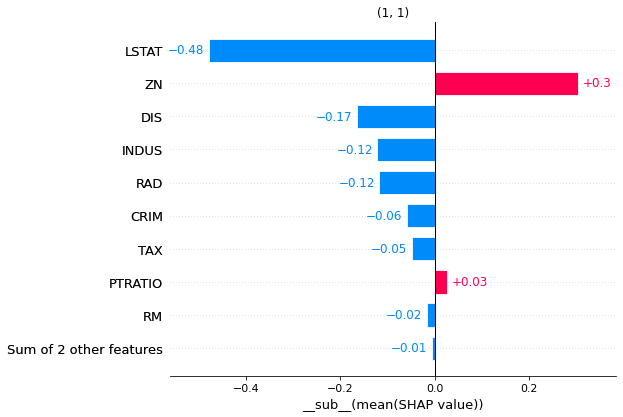

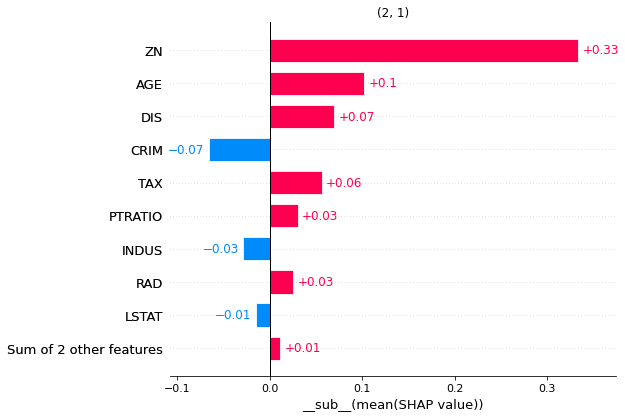

In [88]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [89]:
top_features = ['ZN', 'DIS', 'INDUS', 'RAD']

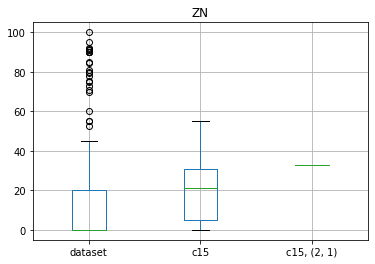

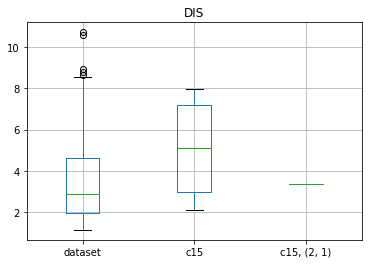

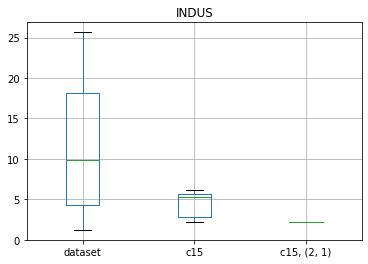

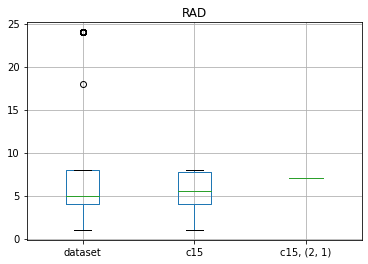

In [90]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

### Feature effects

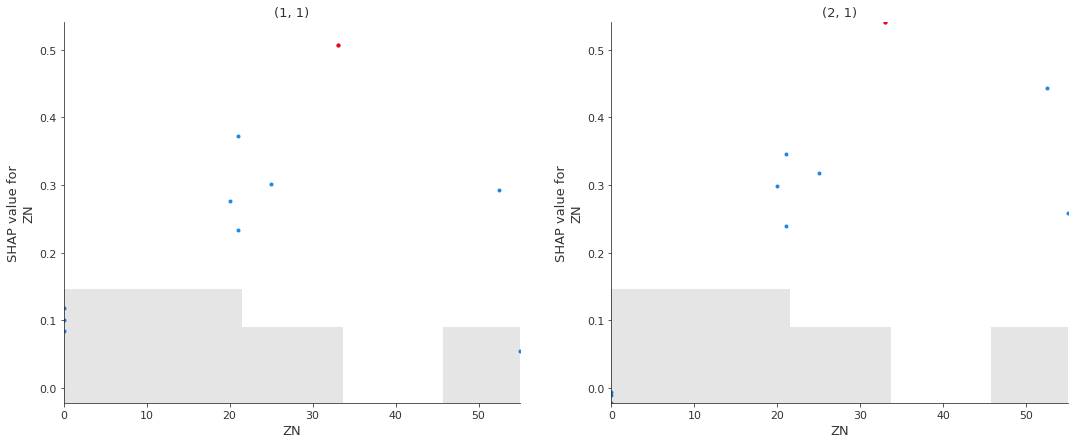

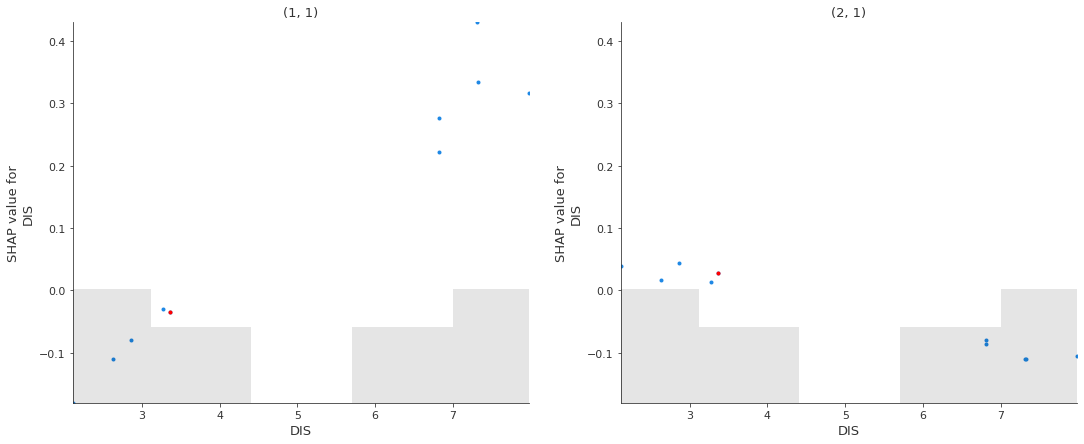

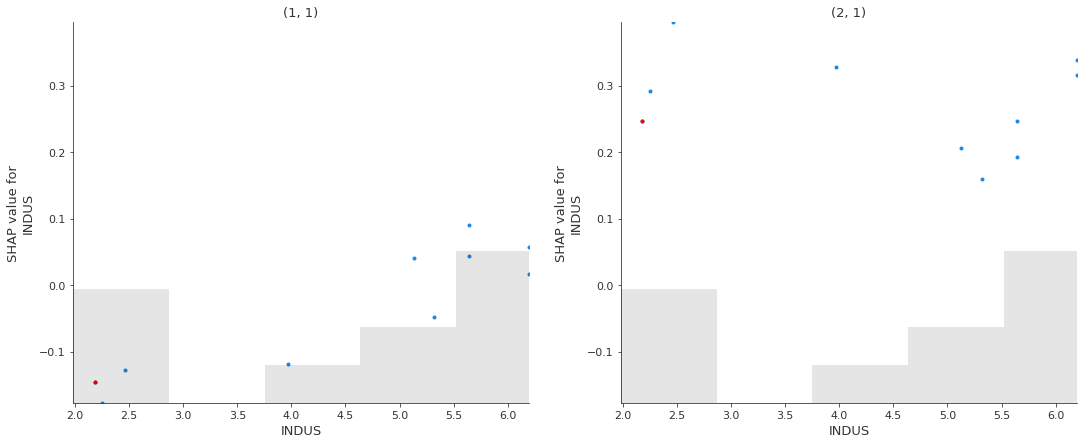

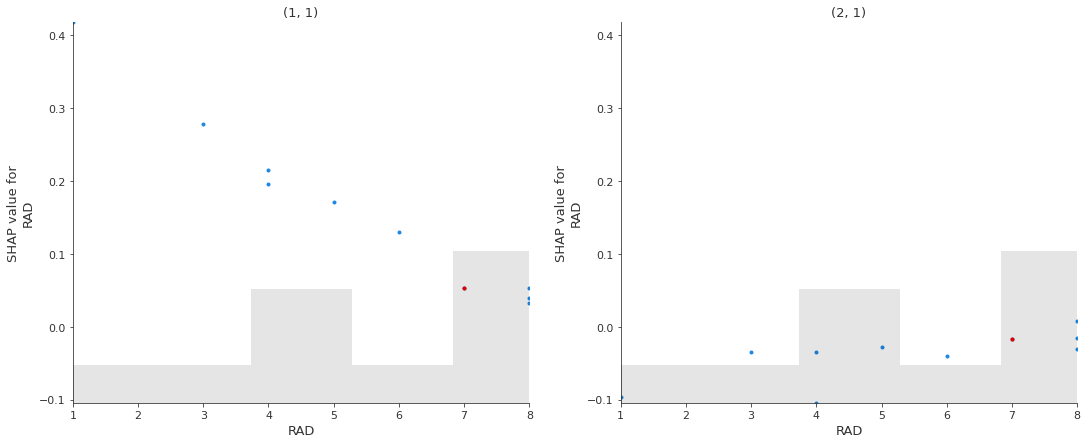

In [91]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the features' values, I found out that the classifiers don't always agree for these instances in the ranges:
- ZN: 24.3-61.12
- DIS: 2.62-3.65
- INDUS: up to 2.86
- RAD: 6.39-9.31

In [92]:
idx_feature = feature_idx_of('ZN')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [33.]
stop:  [24.33]


In [93]:
idx_feature = feature_idx_of('ZN')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [33.]
stop:  [61.12]


In [94]:
idx_feature = feature_idx_of('DIS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [3.37]
stop:  [3.65]


In [95]:
idx_feature = feature_idx_of('DIS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [3.37]
stop:  [2.62]


In [96]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [2.18]
stop:  [2.86]


In [97]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [2.18]
stop:  [-0.26]


In [98]:
idx_feature = feature_idx_of('RAD')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [7.]
stop:  [6.39]


In [99]:
idx_feature = feature_idx_of('RAD')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [7.]
stop:  [9.31]


### diro2c

In [100]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 47.5 s, sys: 596 ms, total: 48.1 s
Wall time: 54.8 s


For ZN it sampled unrealistic negative values.  It's hard to make any hypothesis about the local decision boundary with the plot, except that different classifications are very unlikely above 60, confirming the previous finding. For DIS I cannot say anything, differences may have been created with other features.

The algorithm also sampled unrealistic negative values for INDUS, but it shows a hotspot of instances classified differently for values up to 5, with a bit less up to 10. For RAD, the plot is unclear.

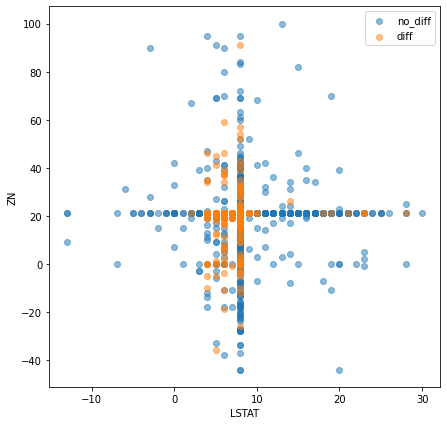

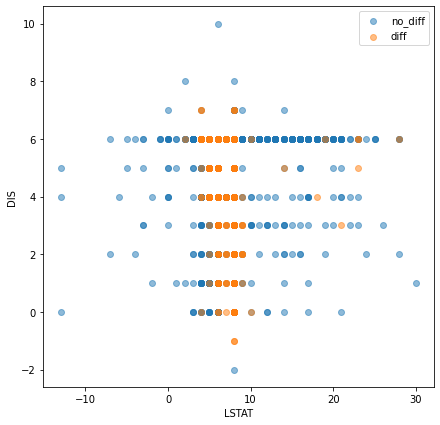

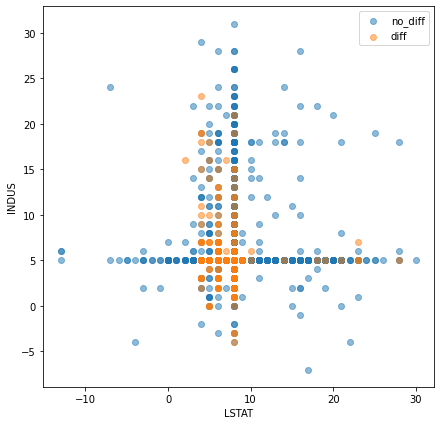

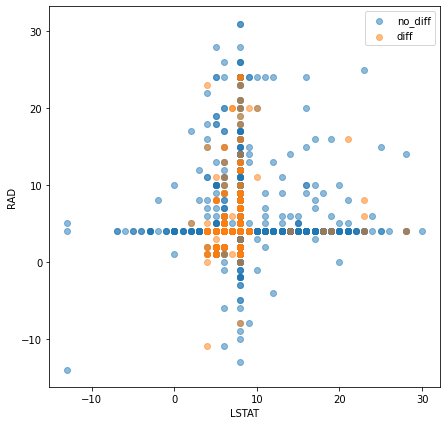

In [101]:
for feature in ['ZN', 'DIS', 'INDUS', 'RAD']:
    plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

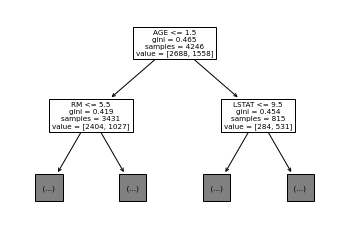

In [102]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 7th cluster (mean LSTAT = 7.6)

In [103]:
cluster = clusters_of_interest[6]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

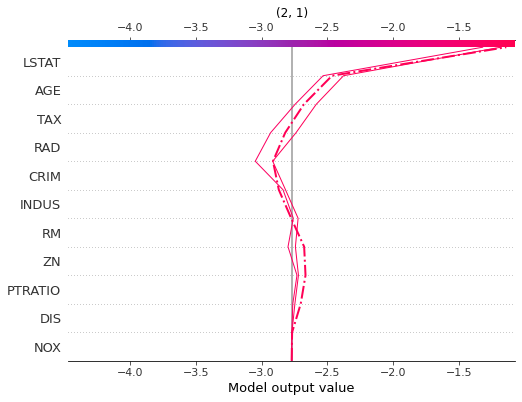

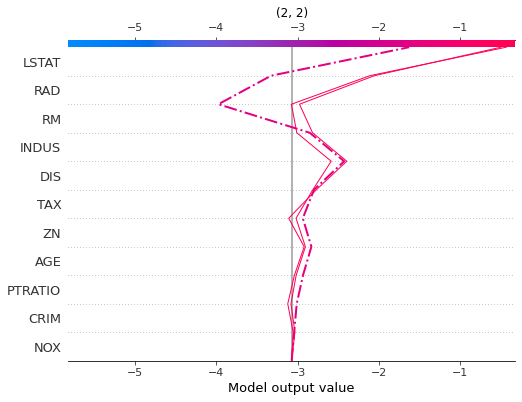

In [104]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

We see that besides LSTAT, CRIM mainly accounts for the differences observed in $(2,1)$, and we see mainly RM, RAD and TAX decreasing the log odds for $(2,2)$.

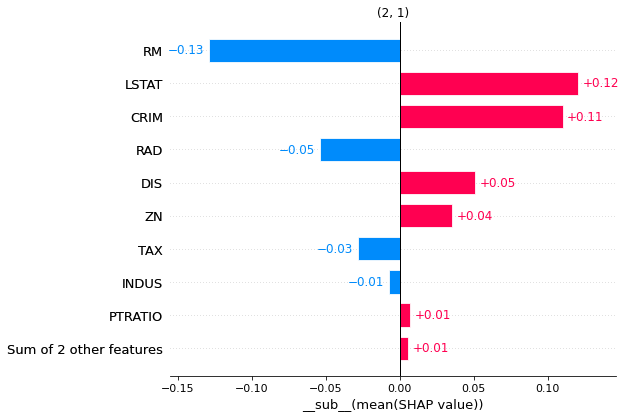

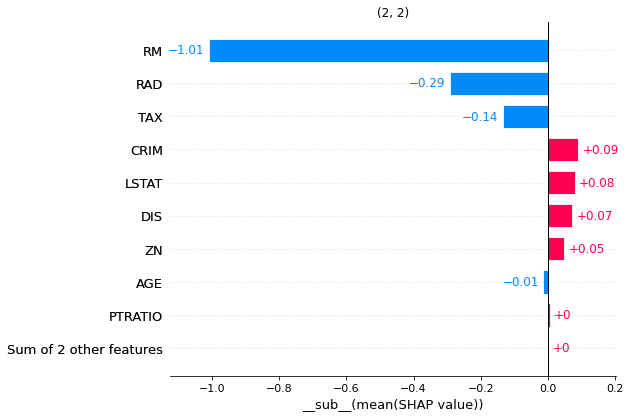

In [105]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [106]:
top_features = ['CRIM', 'RM', 'RAD', 'TAX']

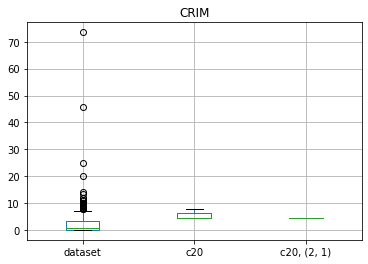

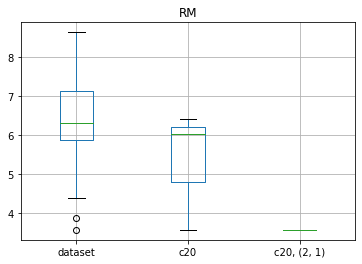

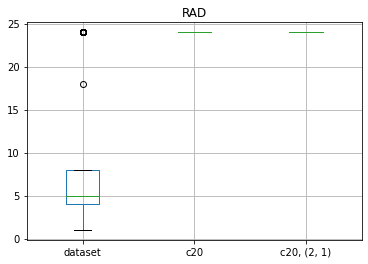

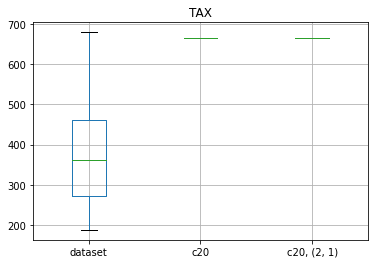

In [107]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

### Feature effects

The effect for CRIM can not be seen well enough, and RAD and TAX only contain the same value for all instances.

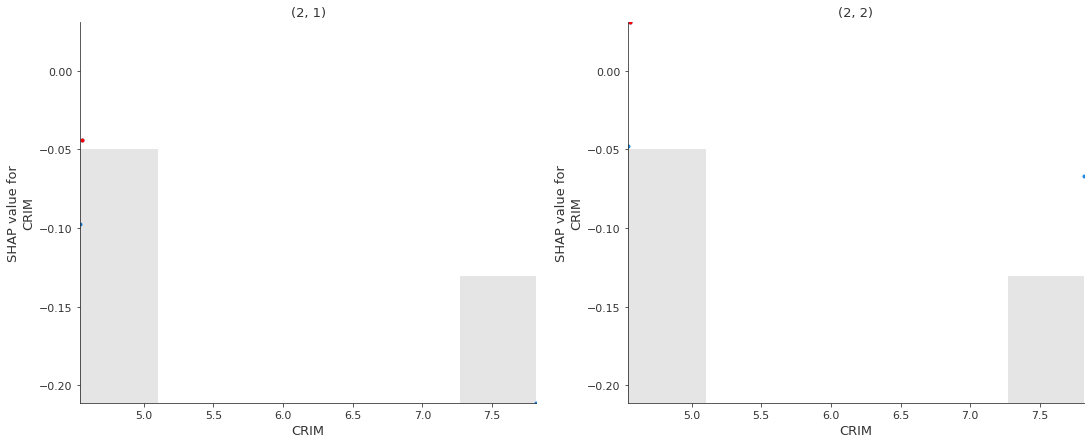

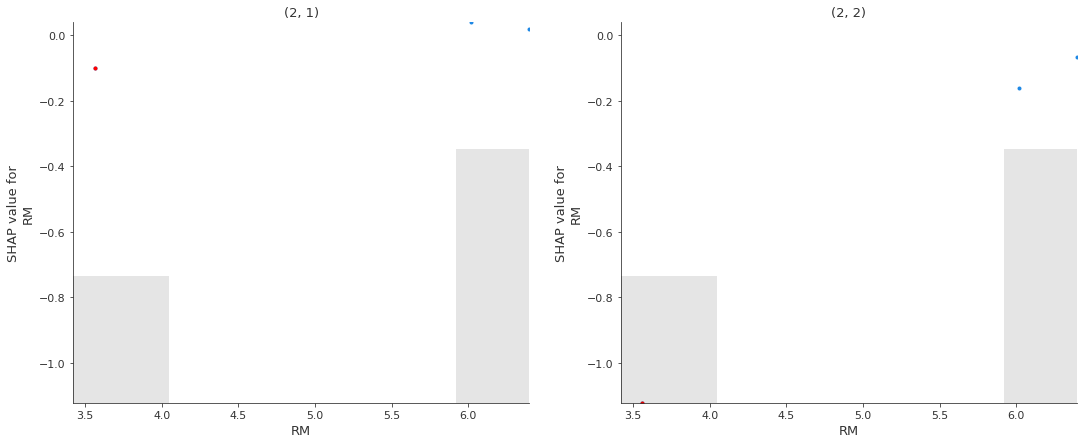

Attempting to set identical left == right == 24.0 results in singular transformations; automatically expanding.


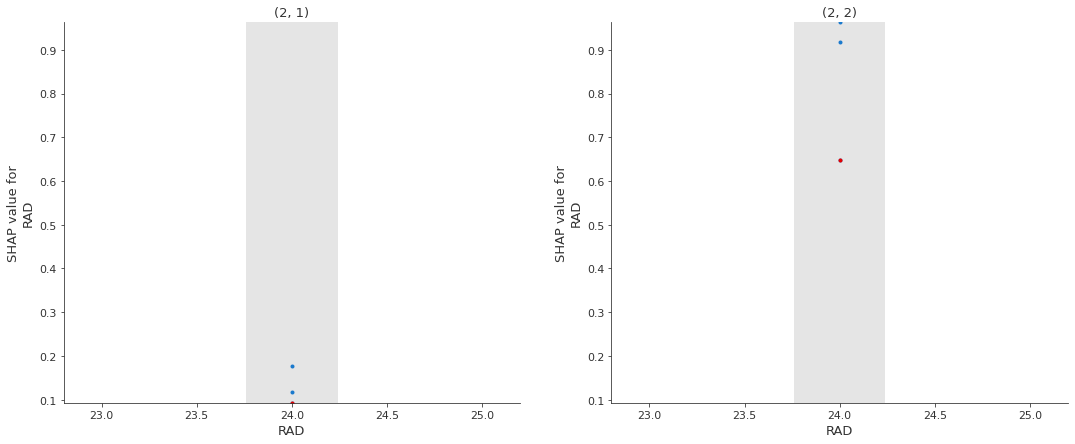

Attempting to set identical left == right == 666.0 results in singular transformations; automatically expanding.


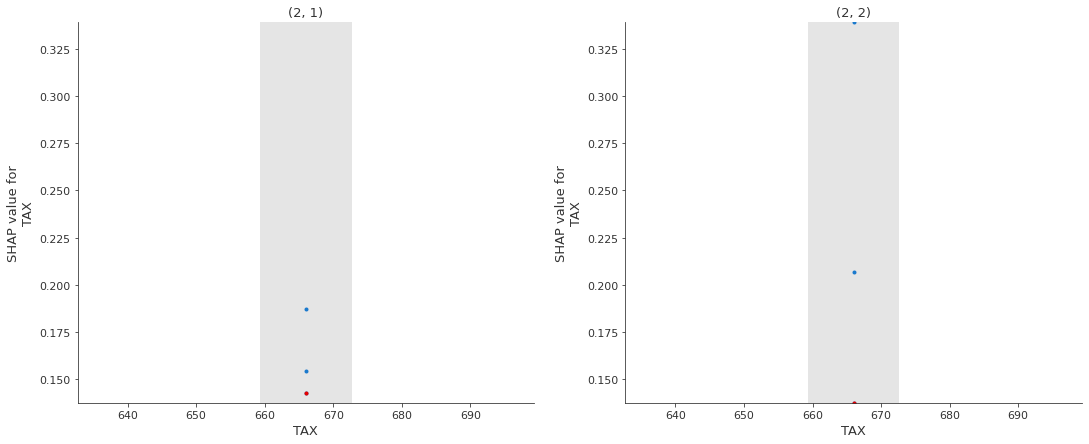

In [108]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the features' values, I found out that the classifiers don't always agree for these instances in the ranges:
- RM: 3.3-4.4

In [109]:
idx_feature = feature_idx_of('RM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [3.561]
stop:  [4.361]


In [110]:
idx_feature = feature_idx_of('RM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [3.561]
stop:  [3.301]


### diro2c

In [111]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 46.7 s, sys: 633 ms, total: 47.3 s
Wall time: 52.7 s


Here it found many differences for higher values of RM, suggesting that the actual decision boundary might be as high as 6 or 7.

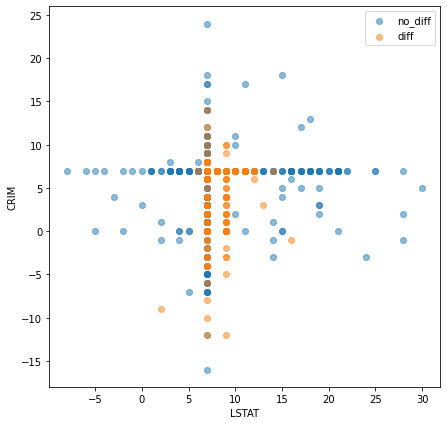

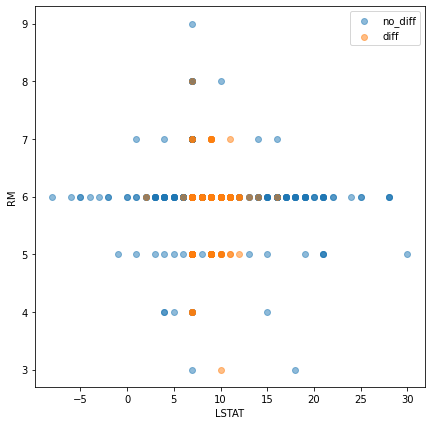

In [112]:
for feature in ['CRIM', 'RM']:
    plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

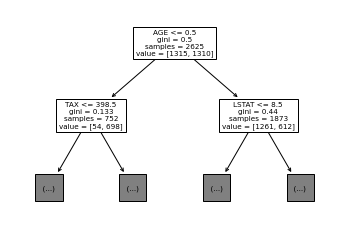

In [113]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 8th cluster (mean LSTAT = 6.8)

In [114]:
cluster = clusters_of_interest[7]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

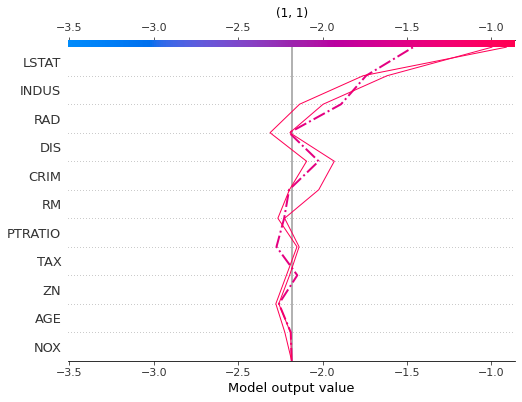

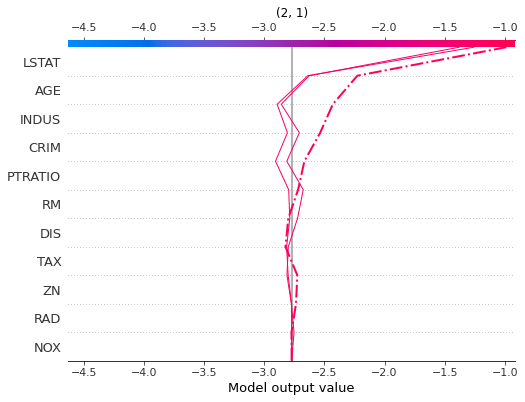

In [115]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

INDUS and PTRATIO are the main differences observed for $(2,1)$, while besides LSTAT, INDUS and TAX are the main differences for $(1,1)$.

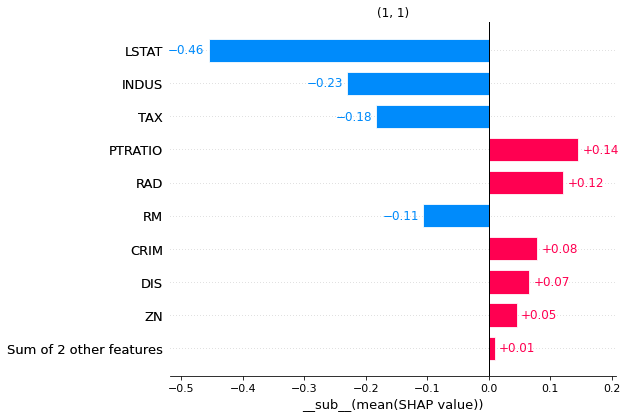

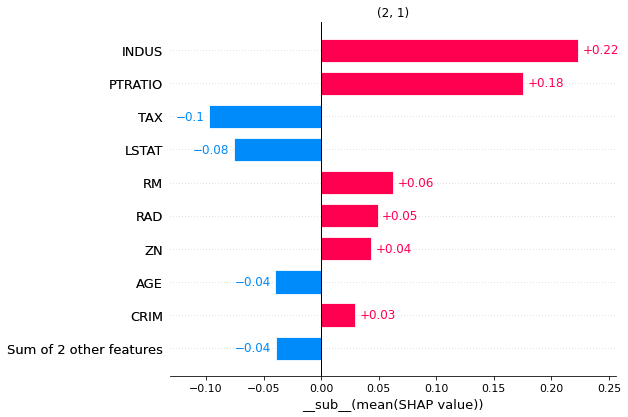

In [116]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [117]:
top_features = ['INDUS', 'PTRATIO', 'TAX']

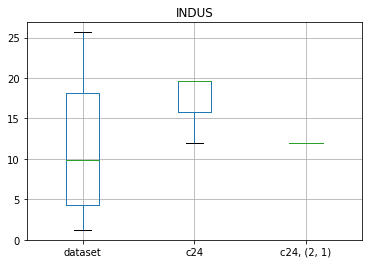

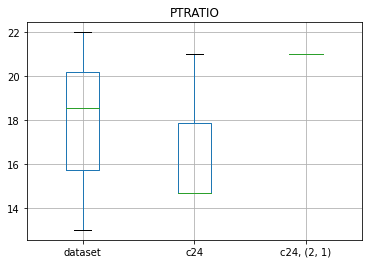

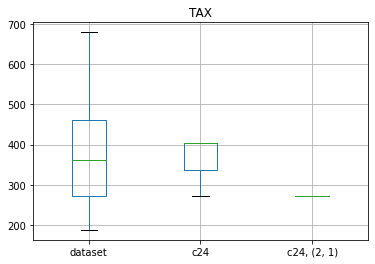

In [118]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

### Feature effects

We see only a clear effect for INDUS, where increasing it should increase the log odds for $(1,1)$

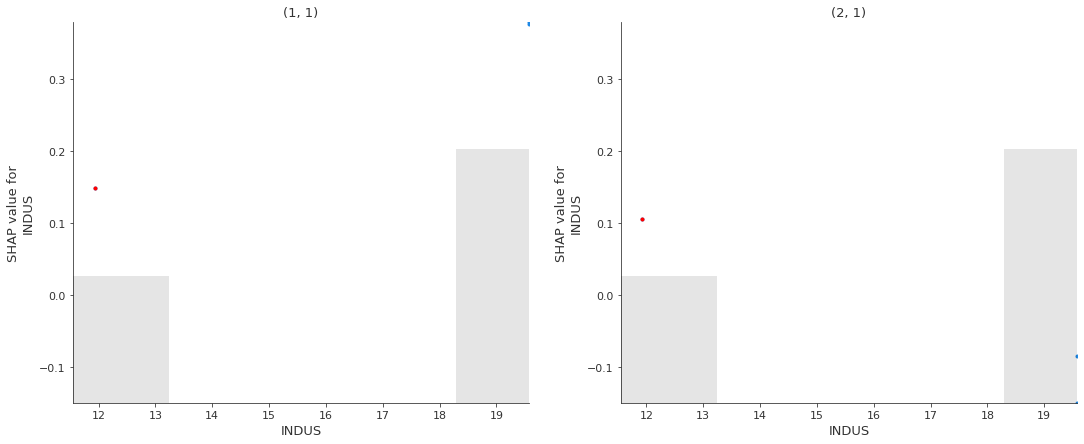

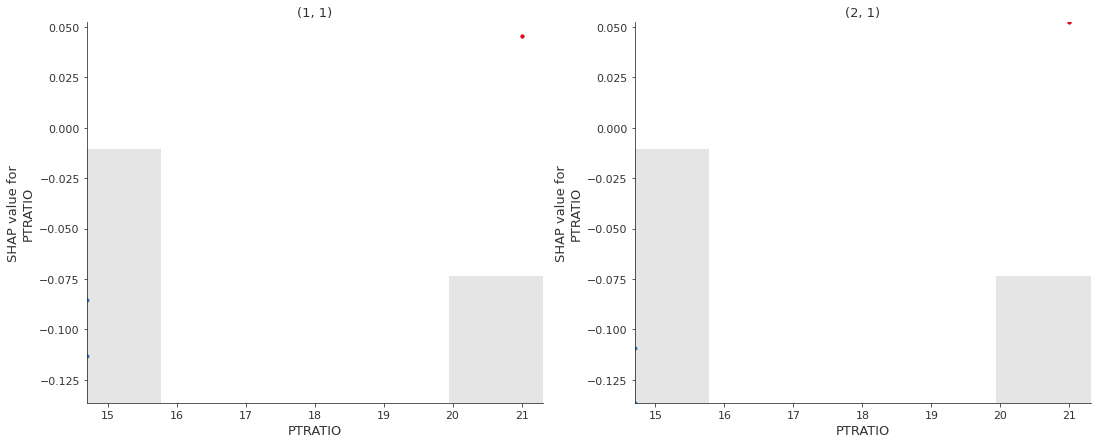

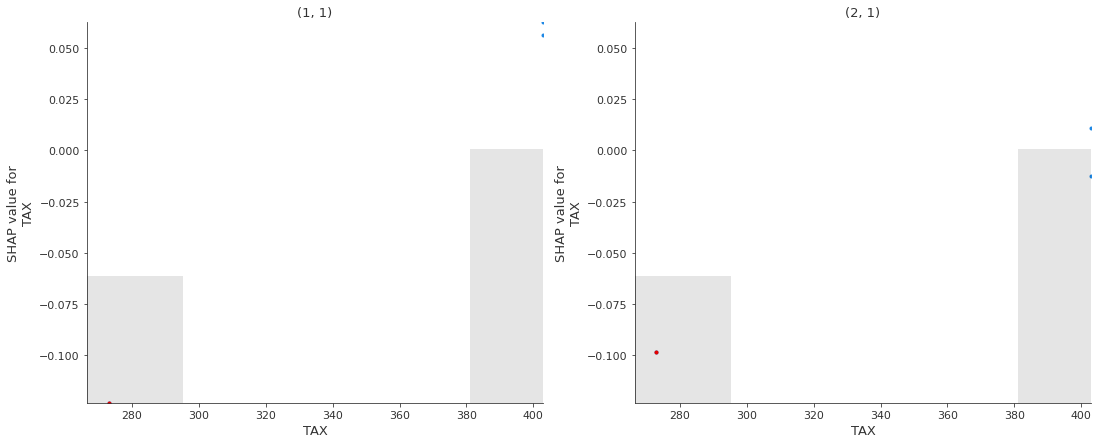

In [119]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the features' values, I found out that the classifiers don't always agree for these instances in the ranges:
- INDUS: 8.8-16.3

In [120]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [11.93]
stop:  [16.32]


In [121]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [11.93]
stop:  [8.77]


### diro2c

In [122]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 48.6 s, sys: 620 ms, total: 49.2 s
Wall time: 58.2 s


We see a hotspot for instances classified differently in the range for INDUS discovered earlier, and the plot suggests it's even a bit broader.

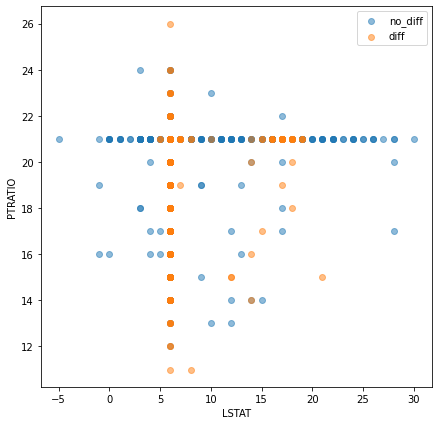

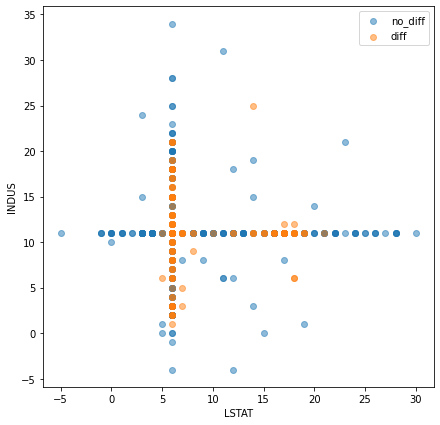

In [123]:
for feature in ['PTRATIO', 'INDUS']:
    plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

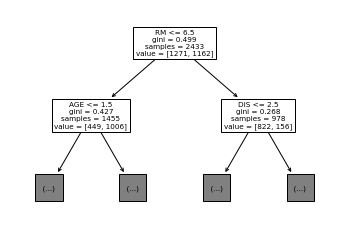

In [124]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 9th cluster (mean LSTAT = 7.4)

In [125]:
cluster = clusters_of_interest[8]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

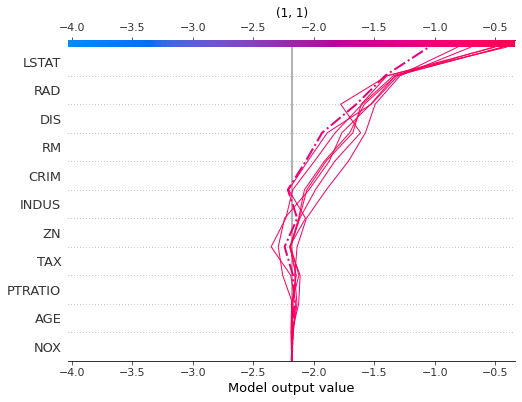

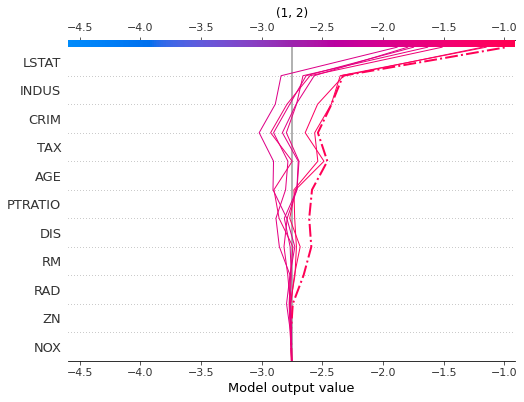

In [126]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

Besides LSTAT, RAD and RM are the main differences observed in $(1,2)$, while INDUS accounts for the main differences in $(1,1)$.

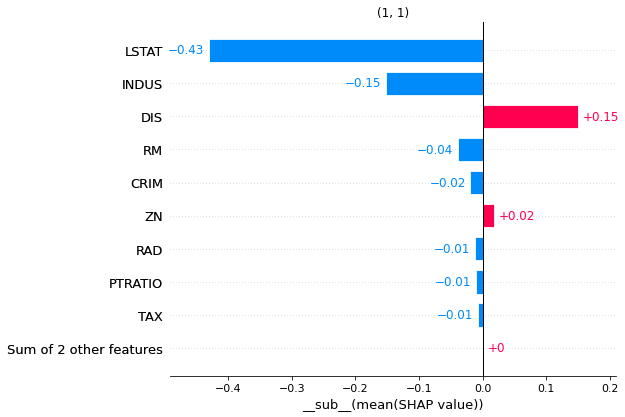

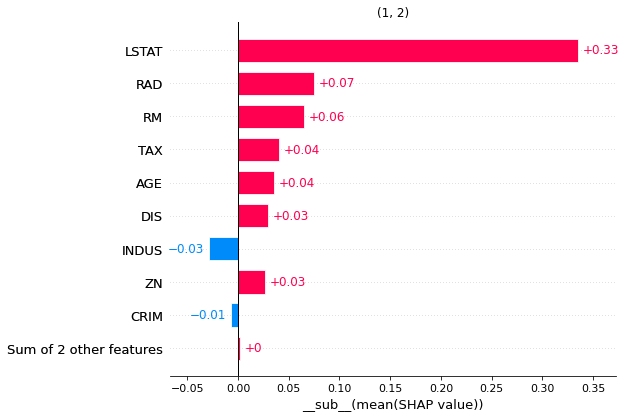

In [127]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [128]:
top_features = ['INDUS', 'RAD', 'RM']

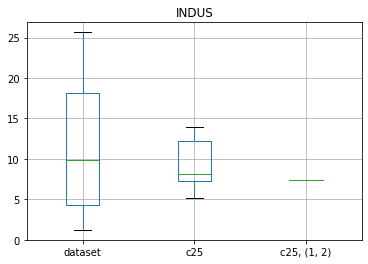

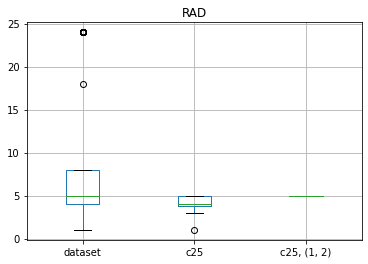

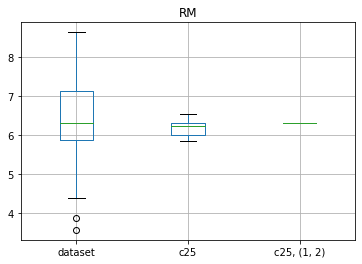

In [129]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()

### Feature effects

We see only a clear effect for INDUS, where increasing it should increase the log odds for $(1,1)$

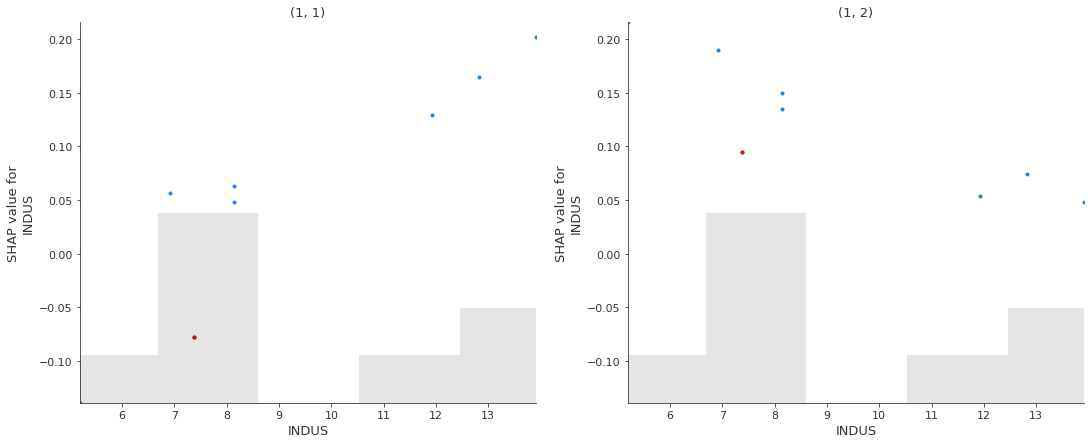

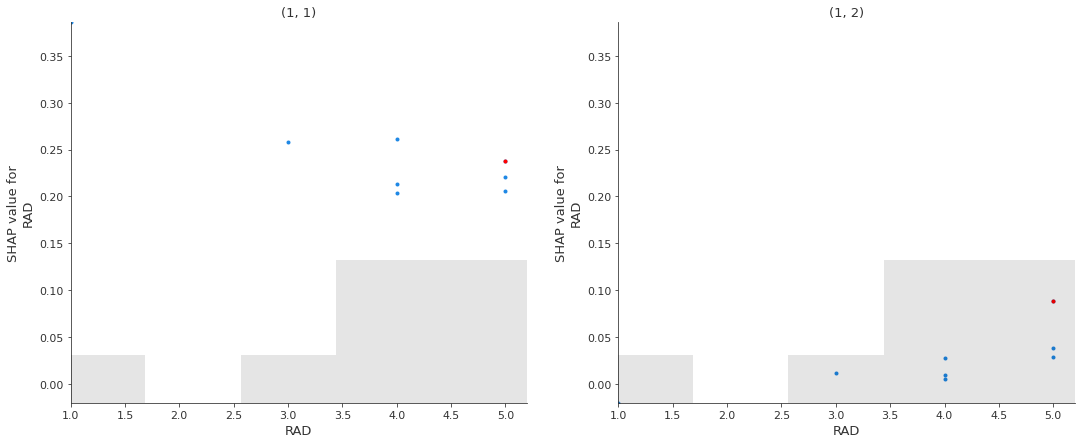

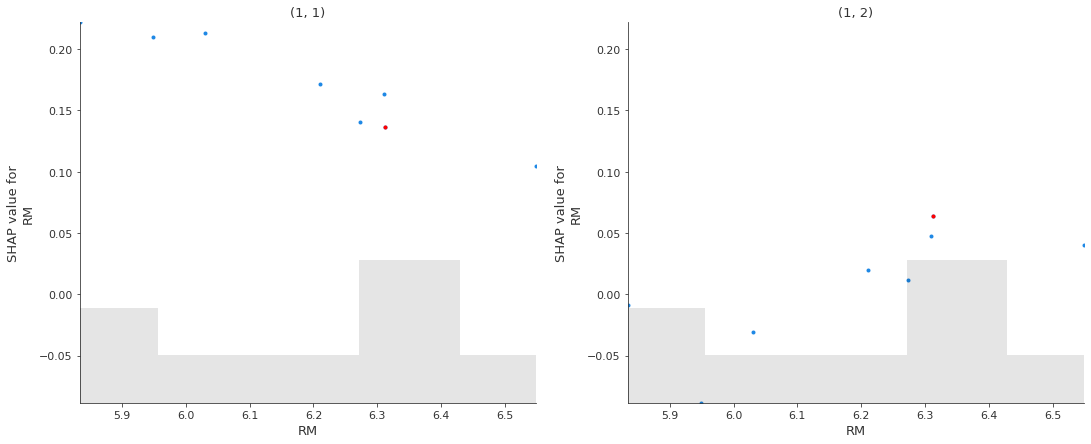

In [130]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the features' values, I found out that the classifiers don't always agree for these instances in the ranges:
- INDUS: up to 8.15
- RAD: 4.27-12.73
- RM: 6.2-7.8

In [131]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [7.38]
stop:  [8.15]


In [132]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [7.38]
stop:  [-1.27]


In [133]:
idx_feature = feature_idx_of('RAD')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [5.]
stop:  [4.27]


In [134]:
idx_feature = feature_idx_of('RAD')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [5.]
stop:  [12.73]


In [135]:
idx_feature = feature_idx_of('RM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] -= 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [6.312]
stop:  [6.202]


In [136]:
idx_feature = feature_idx_of('RM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(2, 2)'):
    d[:, idx_feature] += 0.01
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [6.312]
stop:  [7.752]


### diro2c

In [137]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 44 s, sys: 426 ms, total: 44.4 s
Wall time: 48 s


The previously found boundaries for RAD seem to be confirmed, but may extend down to 0. The boundaries for INDUS are confirmed as well, but it suggests another cluster with different predictions for higher values.

For RM we'd need further samples for lower values to be able to interpret the plot correctly.

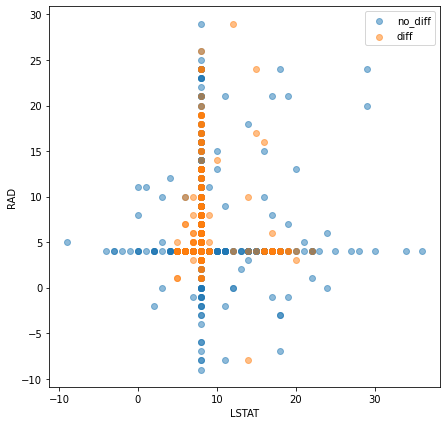

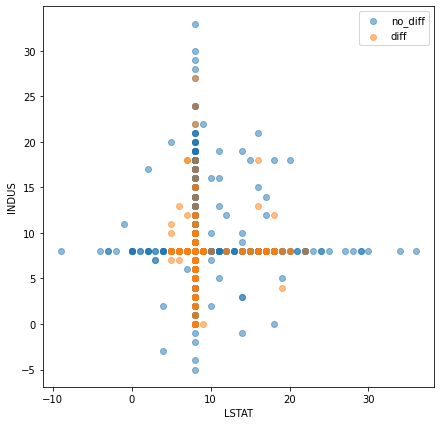

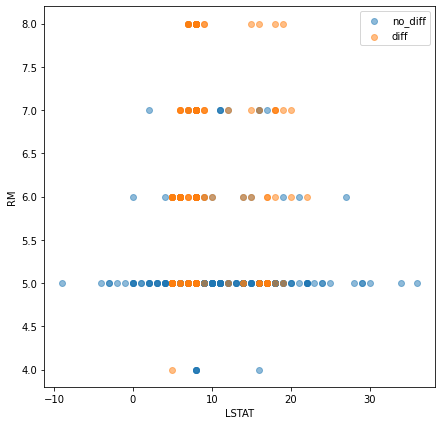

In [138]:
for feature in ['RAD', 'INDUS', 'RM']:
    plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

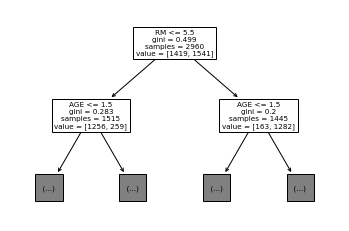

In [139]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

# Conclusion

The local approach, where instances are clustered based on their SHAP-values, groups instances and provides local context for explanations. There are many possibilities to do this. First, I tried to investigate only the instances with different predictions for each confsion class separately, and additionally cluster the bigger group $(0,1)$, that has 13 instances. But then I tried to use supervised clustering, by training a regression tree on the original data to predict the SHAP values, and use the leafs as "clusters". Finally I tried this approach, where I used a hierarchical clustering algorithm to cluster SHAP values of the difference classifier. I chose it because it includes also instances in each cluster, that weren't predicted differently but are similar in terms of their SHAP values and thus provide the possibility to compare them because of the unique properties of the SHAP values. Furthermore, it's difficult to extract meaningful clusters from the tree-based approach, and with this approach, any number of clusters can be extracted easily until a set of similarly sized clusters is obtained.

**Quality criteria for the SHAP explanations:**
- contrastive - The local explanations shown here are especially contrastive, because for every group of similar instances with different outcomes other instances with equal outcomes but similar influences are selected. In the bar plot, I used the unique properties of SHAP values, to aggregate them and contrast them (subtraction), to easily find what is unique about them and investigate further using SHAP dependence plots.
- selectiveness - The shown explanations are selective, because instances with similar SHAP values are selected, and for each group only the most relevant features are analyzed in detail. 
- generalization - The generalization is low for local explanations, which is good, because I created explanations with high generalization already with the global approach, and these now extend the previous findings.

**Quality criteria for the diro2c explanations:**
- contrastive - The plots provide a good way to contrast instances with equal outcomes to instances with different outcomes.
- selectiveness - On a local level, it's selective in terms of the starting instance. But how to choose the starting instance? In this approach, it's a good combination with the SHAP based clustering, because we can select an instance from each cluster. It's still hard to interpret with a medium number of features.
- generalization - The provided explanations are only valid on a local level.

**Confidence:**
Initially I was not sure, whether the generated clusters would actually be a good starting point for local explanations. But with each cluster explaining a specific part of the range of LSTAT (which are still overlapping), it seems very plausible that each of them has characteristic decision boundaries. 

The diro2c explanations are difficult to interpret on their own, because they lack a mechanism to select starting instances, but with the combined approach I was able to confirm most of the findings and have an idea, where further decision boundaries might exist, that are not covered by the test dataset.

Overall I'd rate the confidence I have as 2 of 4. With the SHAP based approach I have quite some confidence, that I have found the features besides LSTAT that are mainly responsible for the differences, while they are kept very selected, because I only looked at the differences within the cluster. Of course, there may be more differences, which is what the diro2c approach also suggests, but it's the goal to keep a high selectiveness.